2025-03-14 10:40:10.771 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2025-03-14 10:40:11.992 | INFO     | tf_chpvk_pv.dataset:create_dataset:38 - Processing dataset...
2025-03-14 10:40:13.231 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:163 - Processing dataset complete.
2025-03-14 10:40:13.560 | INFO     | tf_chpvk_pv.dataset:train_test_split_:177 - Creating train and test dataset...
2025-03-14 10:40:13.582 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:211 - Creating train and test dataset complete.


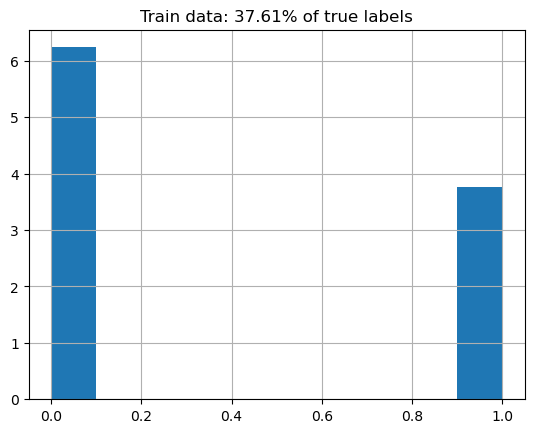

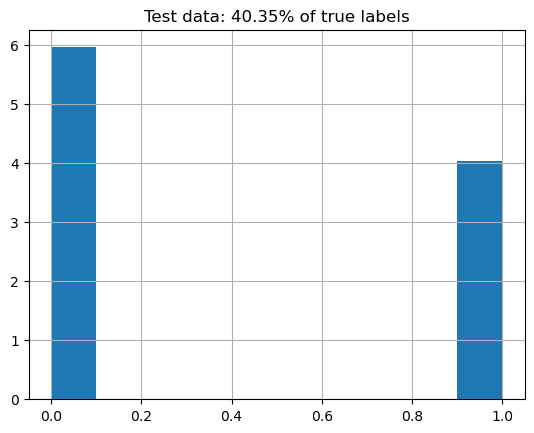

In [1]:
from tf_chpvk_pv.dataset import *
import matplotlib.pyplot as plt
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

train_df.exp_label.hist(density=True)
amount_of_true = train_df[train_df.exp_label == 1].shape[0]/train_df.shape[0]
plt.title('Train data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()
test_df.exp_label.hist(density=True)
amount_of_true = test_df[test_df.exp_label == 1].shape[0]/test_df.shape[0]
plt.title('Test data: {:.2f}% of true labels'.format(amount_of_true*100))
plt.show()

In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133.15:'F',
           180.61:'Cl',
           198.14:'Se',
           195.56:'Br',
           184.40:'S',
           219.49:'I'
          }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

In [3]:
import glob as gl
from tf_chpvk_pv.config import DATA_DIR

features_path = DATA_DIR / 'features_space/features/features/'

files = gl.glob('*.csv', root_dir=features_path)

Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.868341 < t < 0.909563 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.884956.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.880290.
Classification tree accuracy (for tau) on the test set: 0.824561.
tau < 4.180000 indicates stable perovskites.
Classification tree accuracy (for t_jess) on the train set: 0.725664.
Classification tree accuracy (for t_jess) on the train set (5 fold CV): 0.685990.
Classification tree accuracy (for t_jess) on the test set: 0.631579.
0.835219 < t_jess < 1.022730 indicates stable perovskites.
Tree with operations idx = 237 already exists
Tree with operations idx = 78 already exists
Tree with operations idx = 214 already exists
Tree with operations idx = 27 already exists
Tree with operations 

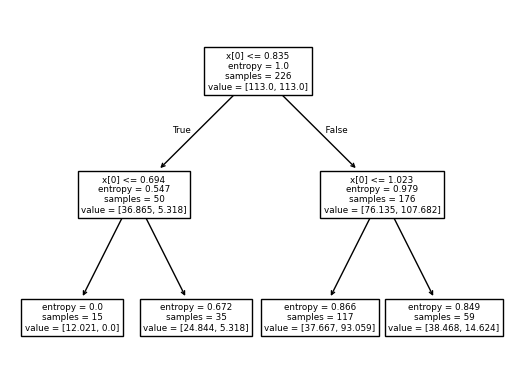

In [4]:
from tf_chpvk_pv.modeling.train import *
from pathlib import Path
from tf_chpvk_pv.config import DATA_DIR, RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'tolerance factors accuracy for several operations.csv'

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

features_path = DATA_DIR / 'features_space/features/features/'

df_acc_old = pd.read_csv(df_acc_old_path)

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}
t_sisso_expressions = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    #check that the tree file doesn't exist
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])

    col = 't_sisso_' + str(idx)
    
    re_do = False

    if col in df_acc_old.columns:
        no_nan_values = df_acc_old[col].isna().sum()
        if no_nan_values == 0:
            print('Tree with operations idx = %s already exists' % str(idx))
            continue
        else:
            print('Tree with operations idx = %s has %s missing values' % (str(idx), no_nan_values))
            re_do = True
    else:
        re_do = True

    if re_do:
        try:
            tf = 't_sisso_' + str(idx)
            df = pd.read_csv(features_path / feat)
            t_sisso_expression = train_tree_sis_features(features_path / feat)
            train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
            df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
            clfs[tf] = clf_t
        except:
            print('Error in %s' % feat)
            continue

In [5]:
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'tolerance factors accuracy for several operations.csv'

if df_acc_old_path.exists():

    df_acc_old = pd.read_csv(df_acc_old_path)
    df_acc_old.set_index('Unnamed: 0', inplace=True)
    df_acc_old.index.name = None

    for col in df_acc.columns:
        if col not in df_acc_old.columns:
            
            df_acc_old[col] = df_acc[col]
        else:
            no_nan_values = df_acc_old[col].isna().sum()
            if no_nan_values > 0:
                df_acc_old[col] = df_acc[col]

    for col in df_acc_old.columns:
        if 'Unnamed' in col:
            df_acc_old.drop(col, axis=1, inplace=True)
    
    df_acc_old.to_csv(df_acc_old_path)

else:
    df_acc.to_csv(df_acc_old_path)

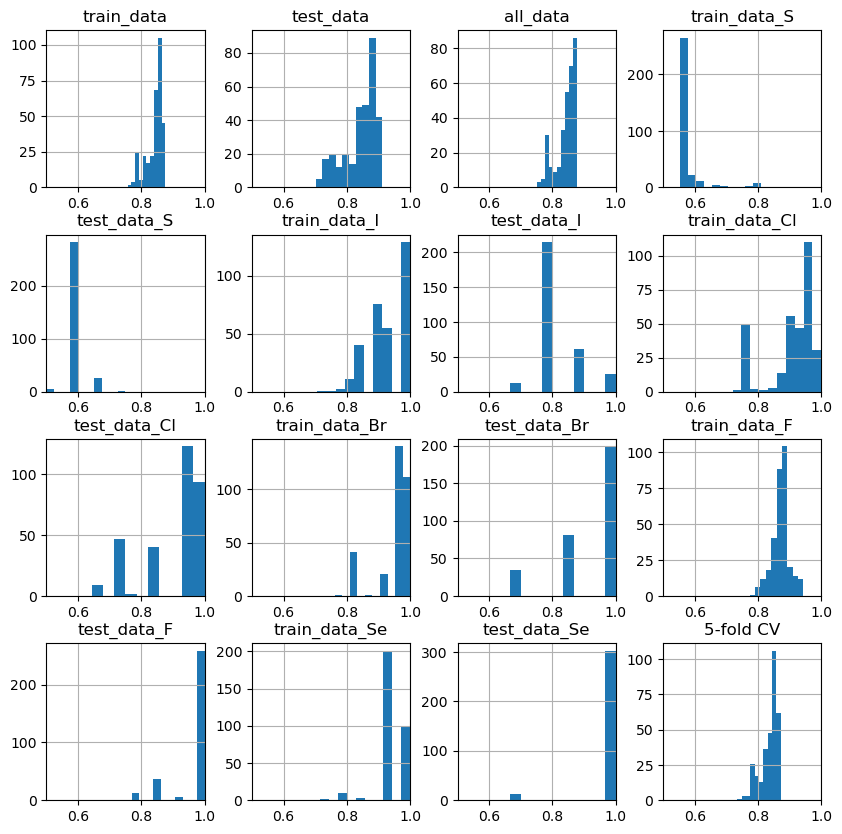

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from tf_chpvk_pv.config import RESULTS_DIR

df_acc_old_path = RESULTS_DIR / 'tolerance factors accuracy for several operations.csv'

df = pd.read_csv(df_acc_old_path)
df.set_index('Unnamed: 0', inplace=True)


axs = df[[x for x in df.columns if 't_sisso' in x]].T.hist(figsize=(10, 10))
for ax in axs.flatten():
    ax.set_xlim(0.5, 1)
plt.show()

In [7]:
df[[x for x in df.columns if 't_sisso' in x]].max(axis=1)

Unnamed: 0
train_data       0.876106
test_data        0.912281
all_data         0.876325
train_data_S     0.808511
test_data_S      0.750000
train_data_I     1.000000
test_data_I      1.000000
train_data_Cl    1.000000
test_data_Cl     1.000000
train_data_Br    1.000000
test_data_Br     1.000000
train_data_F     0.943396
test_data_F      1.000000
train_data_Se    1.000000
test_data_Se     1.000000
5-fold CV        0.871401
dtype: float64

In [8]:
top_10 = df.T.sort_values('test_data', ascending=False).head(10).index.values

df.T.sort_values('test_data', ascending=False).head(10)

Unnamed: 0,train_data,test_data,all_data,train_data_S,test_data_S,train_data_I,test_data_I,train_data_Cl,test_data_Cl,train_data_Br,test_data_Br,train_data_F,test_data_F,train_data_Se,test_data_Se,5-fold CV
t_sisso_60,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_56,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_43,0.858407,0.912281,0.869258,0.574468,0.583333,0.970588,1.0,0.947368,1.000000,0.952381,1.0,0.886792,1.0,0.928571,1.0,0.858068
t_sisso_127,0.858407,0.912281,0.869258,0.574468,0.583333,0.970588,1.0,0.947368,1.000000,0.952381,1.0,0.886792,1.0,0.928571,1.0,0.858068
t_sisso_55,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_50,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_49,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_58,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_61,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_57,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.0,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623


Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.868341 < t < 0.909563 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.884956.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.880290.
Classification tree accuracy (for tau) on the test set: 0.824561.
tau < 4.180000 indicates stable perovskites.
Classification tree accuracy (for t_jess) on the train set: 0.725664.
Classification tree accuracy (for t_jess) on the train set (5 fold CV): 0.685990.
Classification tree accuracy (for t_jess) on the test set: 0.631579.
0.835219 < t_jess < 1.022730 indicates stable perovskites.
2025-03-14 10:40:15.844 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:76 - Training tree model with SISSO features...
Identified expression for t_sisso: log((|(|rB_rX_ratio - log_rA_rB_

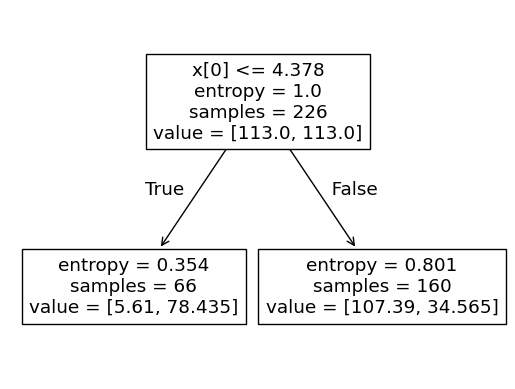

In [9]:
from tf_chpvk_pv.config import DATA_DIR, INTERIM_DATA_DIR
from tf_chpvk_pv.modeling.train import test_tolerance_factor, evaluate_t_sisso, train_tree_sis_features
import pickle

features_path = DATA_DIR / 'features_space/features/features/'

tfs = ['t', 'tau', 't_jess'] + top_10.tolist()
tf_tresh = [2, 1, 2] + [1]*10
df_acc =pd.DataFrame()
clfs = {}

tolerance_factor_path = INTERIM_DATA_DIR / 'tolerance_factors_ops.pkl'

tolerance_factor_dict_global = {}

train_df_global = train_df.copy()
test_df_global = test_df.copy()

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

for tf, tresh in zip(tfs, tf_tresh):
    if 'sisso' in tf:
        idx = int(tf.split('_')[-1])
        t_sisso_expression = train_tree_sis_features(features_path / ('features_sisso_' + str(idx) + '.csv'))
        train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    for key in tolerance_factor_dict.keys():
        if key not in tolerance_factor_dict_global.keys():
            tolerance_factor_dict_global[key] = tolerance_factor_dict[key]
    for col in train_df.columns:
        if col not in train_df_global.columns:
            train_df_global[col] = train_df[col]
        if col not in test_df_global.columns:
            test_df_global[col] = test_df[col]
    clfs[tf] = clf_t


with open(tolerance_factor_path, 'wb') as file:
    pickle.dump(tolerance_factor_dict_global, file)

train_df = train_df_global
test_df = test_df_global

2025-03-14 10:45:08.670 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2025-03-14 10:45:09.043 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2025-03-14 10:45:09.088 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:51 - Generating Platt Scaling plot from data...
2025-03-14 10:45:09.437 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:63 - Plot generation complete.
2025-03-14 10:45:09.438 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2025-03-14 10:45:09.565 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2025-03-14 10:45:09.802 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:51 - Generating Platt Scaling plot from data...
2025-03-14 10:45:10.161 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:63 - Plot generation complete.
2025-03-14 10:45:10.161 | INFO     | tf_chpvk_pv

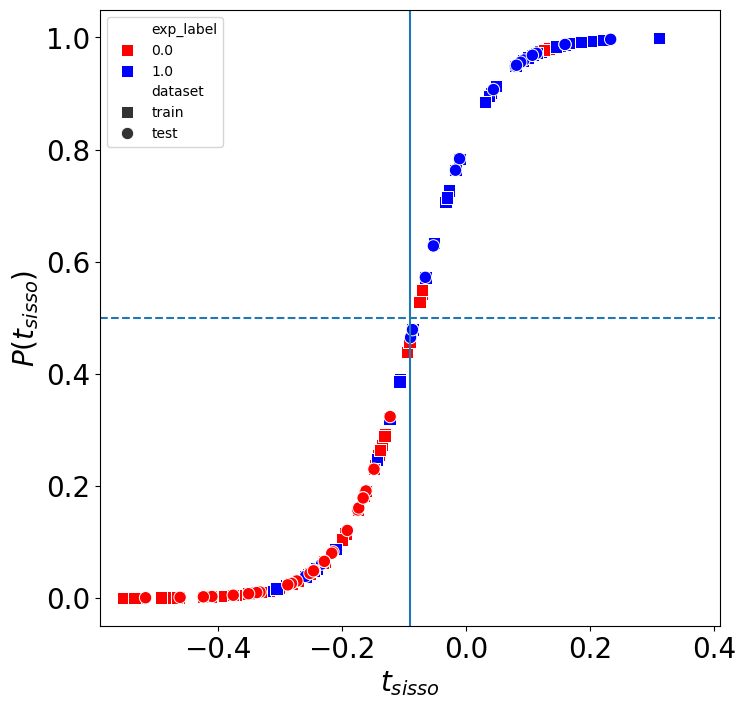

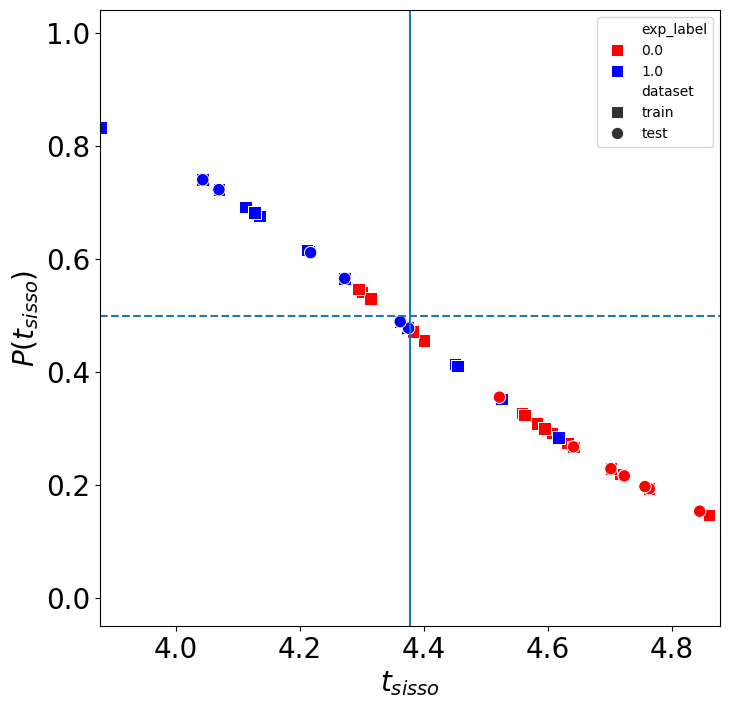

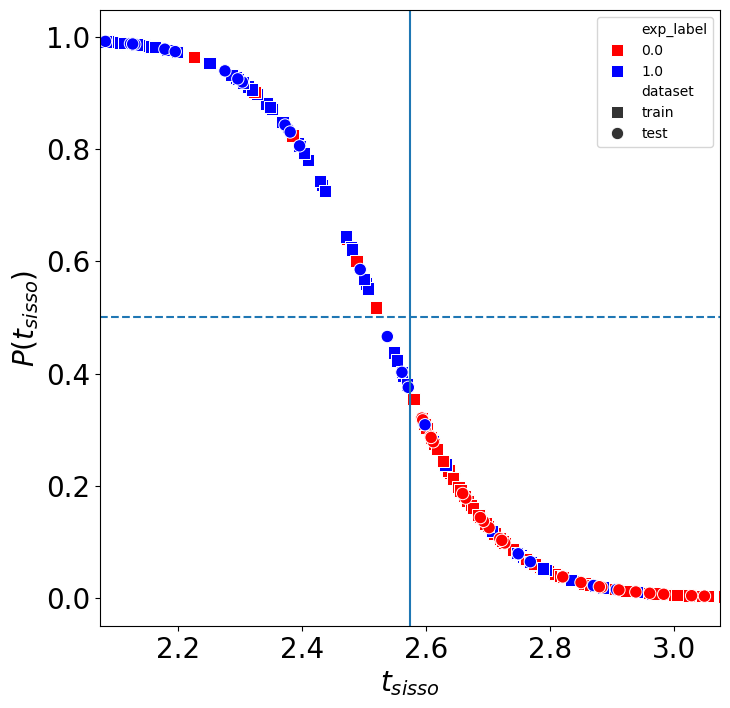

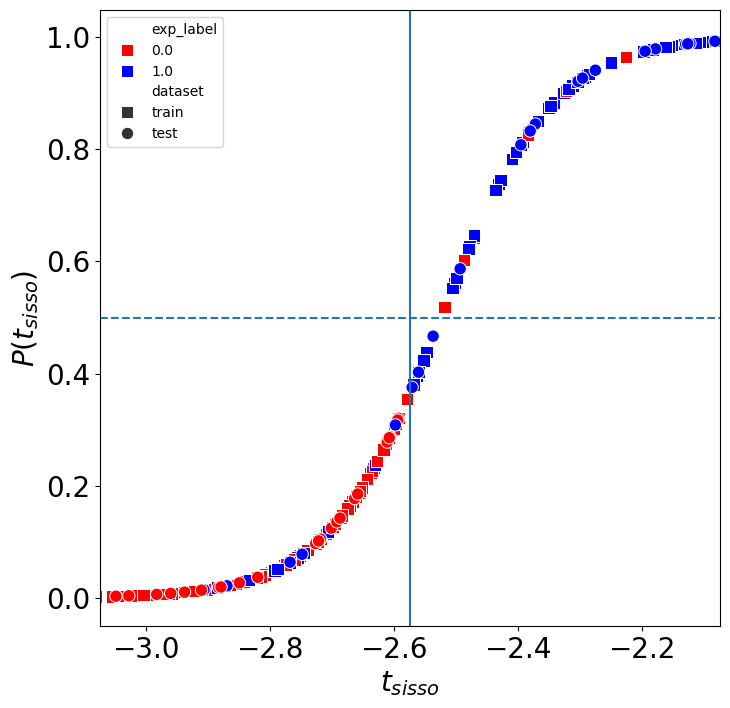

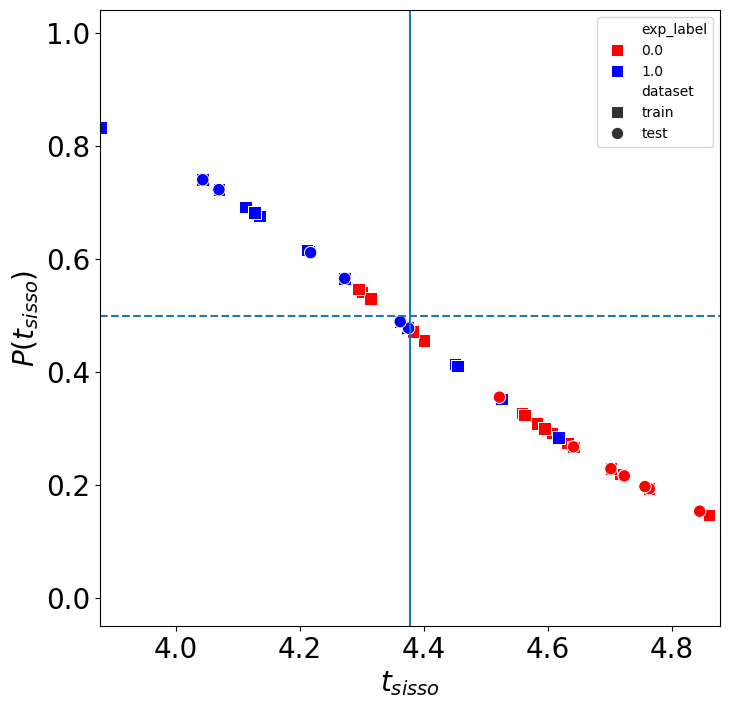

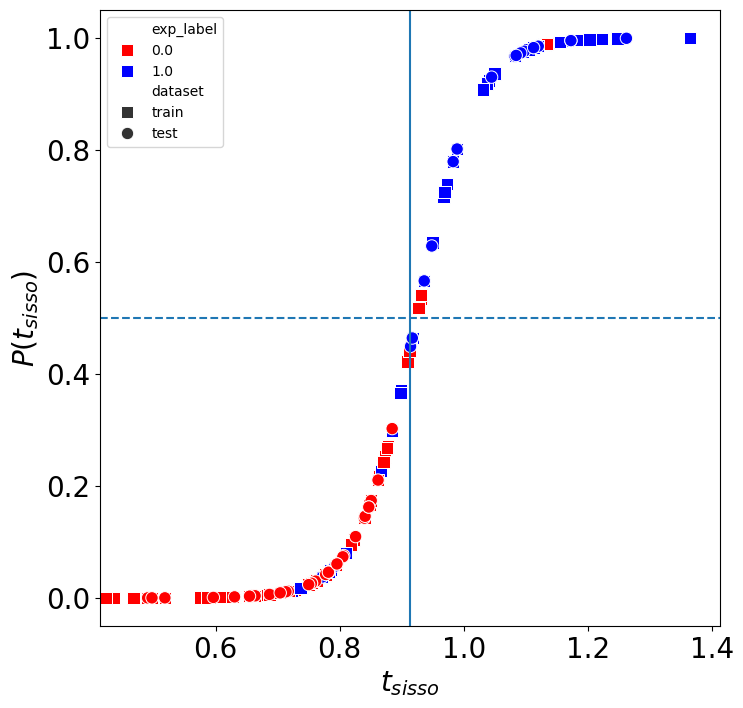

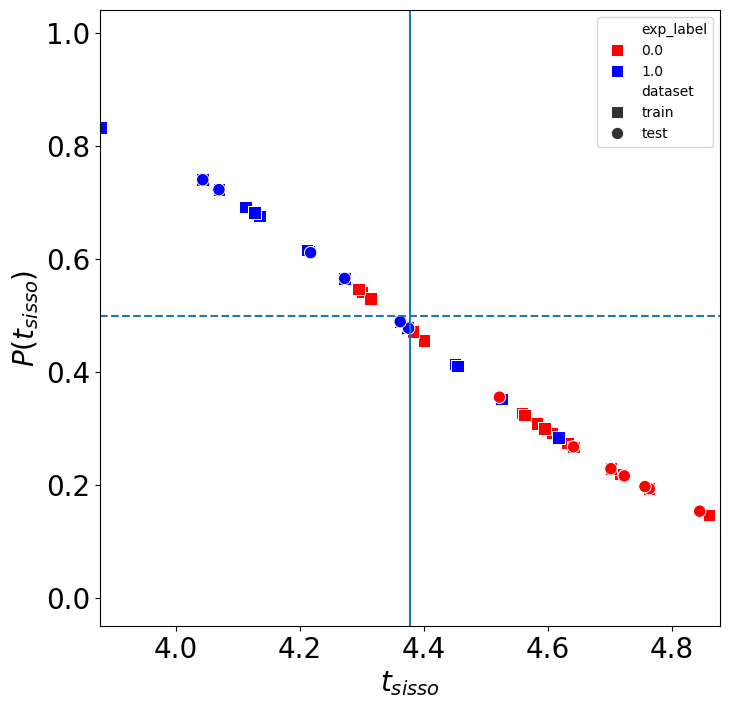

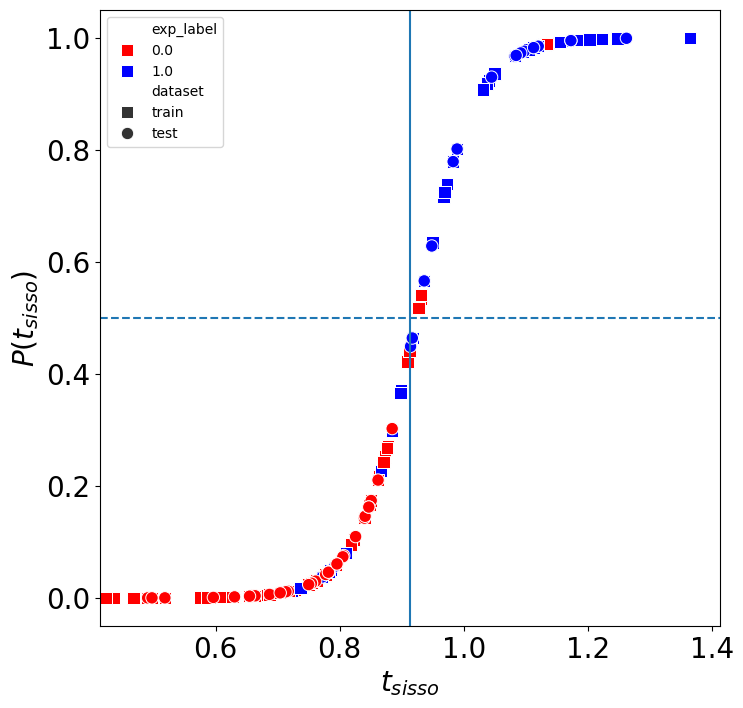

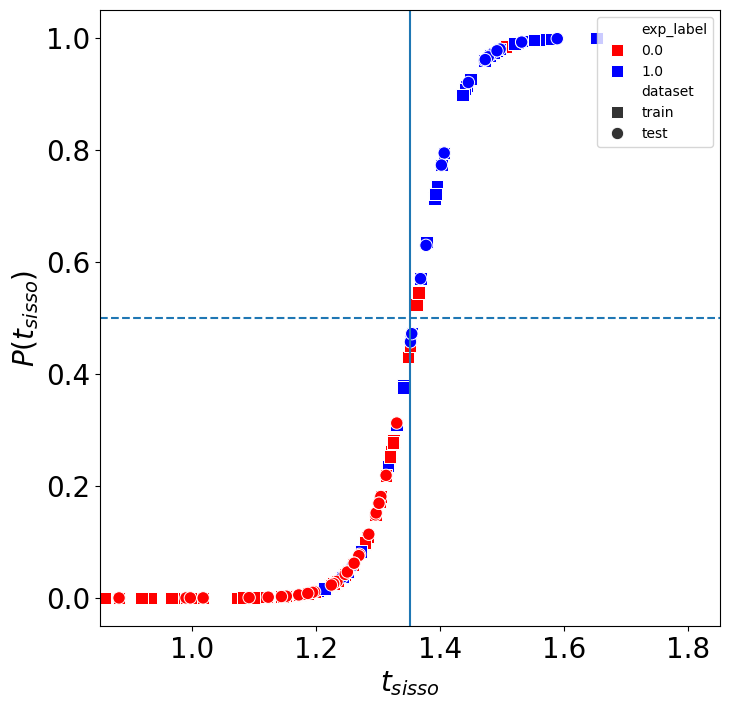

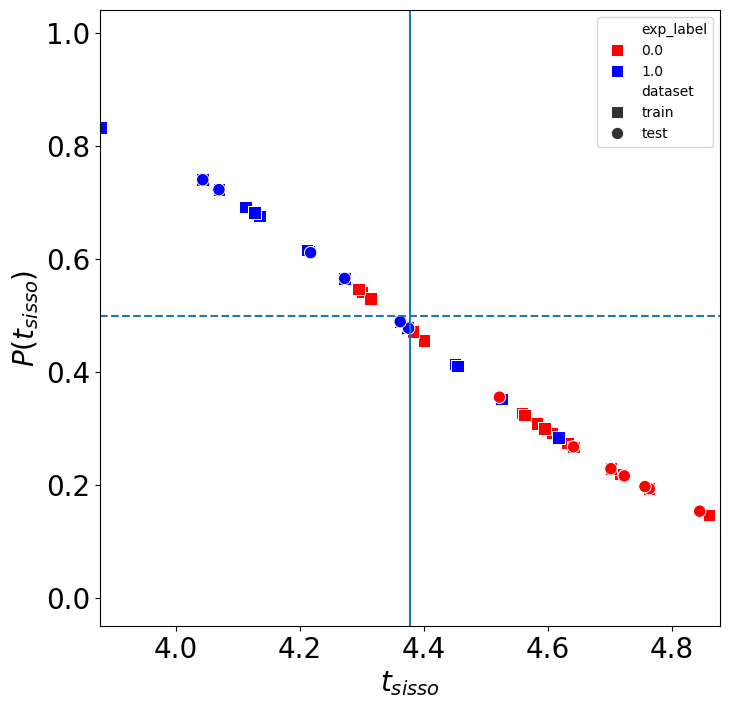

In [10]:
from tf_chpvk_pv.plots import platt_scaling_plot
from tf_chpvk_pv.config import RESULTS_DIR, INTERIM_DATA_DIR, FIGURES_DIR
import os

from tf_chpvk_pv.modeling.train import train_platt_scaling

for t in tolerance_factor_dict_global.keys():
    if 'sisso' in t:
        idx = int(t.split('_')[-1])
        train_df, test_df, clf2_sisso =  train_platt_scaling(train_df, test_df, clf_t=clfs[t], t=t,)

        train_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_train_dataset.csv'
        test_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_test_dataset.csv'
        concat_input_path = RESULTS_DIR / 'diff_ops_processed_chpvk_concat_dataset.csv'
        if concat_input_path.exists():
            os.remove(concat_input_path)
        tolerance_dict_path = INTERIM_DATA_DIR / 'tolerance_factors_ops.pkl'
        txt_output = 'diff_ops_platt_scaling_plot_t_sisso_' + str(idx) + '.png'
        output_path = FIGURES_DIR / txt_output

        platt_scaling_plot(t, train_input_path, test_input_path,concat_input_path, tolerance_dict_path, output_path)

In [11]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions
from tf_chpvk_pv.config import INTERIM_DATA_DIR

new_tolerance_dict_path = INTERIM_DATA_DIR / 'tolerance_factors_ops.pkl'

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]


elements_selection = element_selection_A + elements_selection_B

df_generated_comp = generate_compositions(elements_selection, dict_tol_factors_path=new_tolerance_dict_path).dropna()

2025-03-14 10:45:18.379 | INFO     | tf_chpvk_pv.dataset:generate_compositions:246 - Generating valid compositions...
2025-03-14 10:45:33.369 | SUCCESS  | tf_chpvk_pv.dataset:generate_compositions:407 - 1192 valid compositions generated.


/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
tolerance_factor_dict_global[t][1]

[np.float64(0.868341326713562), np.float64(0.9095631241798401)]

According to tau, 385 (32.29865771812081%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaUS3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuMnS3', 'EuMnSe3', 'CuLaS3', 'CuLaSe3', 'CuGaS3', 'CuAlS3', 'CuAlSe3', 'MgUS3', 'MgUSe3', 'LaYbS3', 'LaYbSe3', 'LaYS3', 'LaYSe3', 'LaHoS3', 'LaHoSe3', 'LaErS3', 'LaErSe3', 'LaTmS3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaScS3', 'LaScSe3', 'LaTlS3', 'LaTlSe3', 'LaVS3', 'LaVSe3', 'LaRhS3', 'LaRhSe3', 'LaTiS3', 'LaTiSe3', 'LaRuS3', 'LaRuSe3', 'LaMoS3', 'LaMoSe3', 'LaTaS3', 'LaTaSe3', 'LaNbS3', 'LaNbSe3', 'LaHfS3', 'LaNiS3', 'LaNiSe3', 'LaCoS3', 'LaCoSe3', 'LaGaS3', 'LaGaSe3', 'LaAlS3', 'LaAlSe3', 'LaFeS3', 'LaFeSe3', 'LaCrS3', 'LaCrSe3', 'LaInS3', 'LaInSe3', 'LaMnS3', 'LaMnSe3', 'PrLuS3', 'PrScS3', 'PrScSe3',

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_60, 1179 (98.90939597315436%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_56, 44 (3.691275167785235%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'CuLaS3', 'CuLaSe3', 'MgUS3', 'LaLuS3', 'RhCeS3', 'RhCeSe3', 'BiYbS3', 'RhYbS3', 'GaYbS3', 'FeYbS3', 'ScYS3', 'RhYS3', 'GaYS3', 'FeYS3', 'ScHoS3', 'RhHoS3', 'GaHoS3', 'FeHoS3', 'ScErS3', 'RhErS3', 'GaErS3', 'FeErS3', 'ScTmS3', 'RhTmS3', 'GaTmS3', 'FeTmS3', 'BiLuS3', 'RhLuS3', 'GaLuS3', 'FeLuS3', 'RhTbS3', 'RhTbSe3', 'RhUS3', 'RhUSe3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_43, 8 (0.6711409395973155%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbCeS3', 'PbUS3', 'SrCeS3', 'SrUS3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_127, 1126 (94.46308724832215%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'E

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_55, 44 (3.691275167785235%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'CuLaS3', 'CuLaSe3', 'MgUS3', 'LaLuS3', 'RhCeS3', 'RhCeSe3', 'BiYbS3', 'RhYbS3', 'GaYbS3', 'FeYbS3', 'ScYS3', 'RhYS3', 'GaYS3', 'FeYS3', 'ScHoS3', 'RhHoS3', 'GaHoS3', 'FeHoS3', 'ScErS3', 'RhErS3', 'GaErS3', 'FeErS3', 'ScTmS3', 'RhTmS3', 'GaTmS3', 'FeTmS3', 'BiLuS3', 'RhLuS3', 'GaLuS3', 'FeLuS3', 'RhTbS3', 'RhTbSe3', 'RhUS3', 'RhUSe3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_50, 1179 (98.90939597315436%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_49, 44 (3.691275167785235%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'CuLaS3', 'CuLaSe3', 'MgUS3', 'LaLuS3', 'RhCeS3', 'RhCeSe3', 'BiYbS3', 'RhYbS3', 'GaYbS3', 'FeYbS3', 'ScYS3', 'RhYS3', 'GaYS3', 'FeYS3', 'ScHoS3', 'RhHoS3', 'GaHoS3', 'FeHoS3', 'ScErS3', 'RhErS3', 'GaErS3', 'FeErS3', 'ScTmS3', 'RhTmS3', 'GaTmS3', 'FeTmS3', 'BiLuS3', 'RhLuS3', 'GaLuS3', 'FeLuS3', 'RhTbS3', 'RhTbSe3', 'RhUS3', 'RhUSe3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_58, 1179 (98.90939597315436%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_61, 1121 (94.04362416107382%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'Eu

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


According to t_sisso_57, 44 (3.691275167785235%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'CuLaS3', 'CuLaSe3', 'MgUS3', 'LaLuS3', 'RhCeS3', 'RhCeSe3', 'BiYbS3', 'RhYbS3', 'GaYbS3', 'FeYbS3', 'ScYS3', 'RhYS3', 'GaYS3', 'FeYS3', 'ScHoS3', 'RhHoS3', 'GaHoS3', 'FeHoS3', 'ScErS3', 'RhErS3', 'GaErS3', 'FeErS3', 'ScTmS3', 'RhTmS3', 'GaTmS3', 'FeTmS3', 'BiLuS3', 'RhLuS3', 'GaLuS3', 'FeLuS3', 'RhTbS3', 'RhTbSe3', 'RhUS3', 'RhUSe3']


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


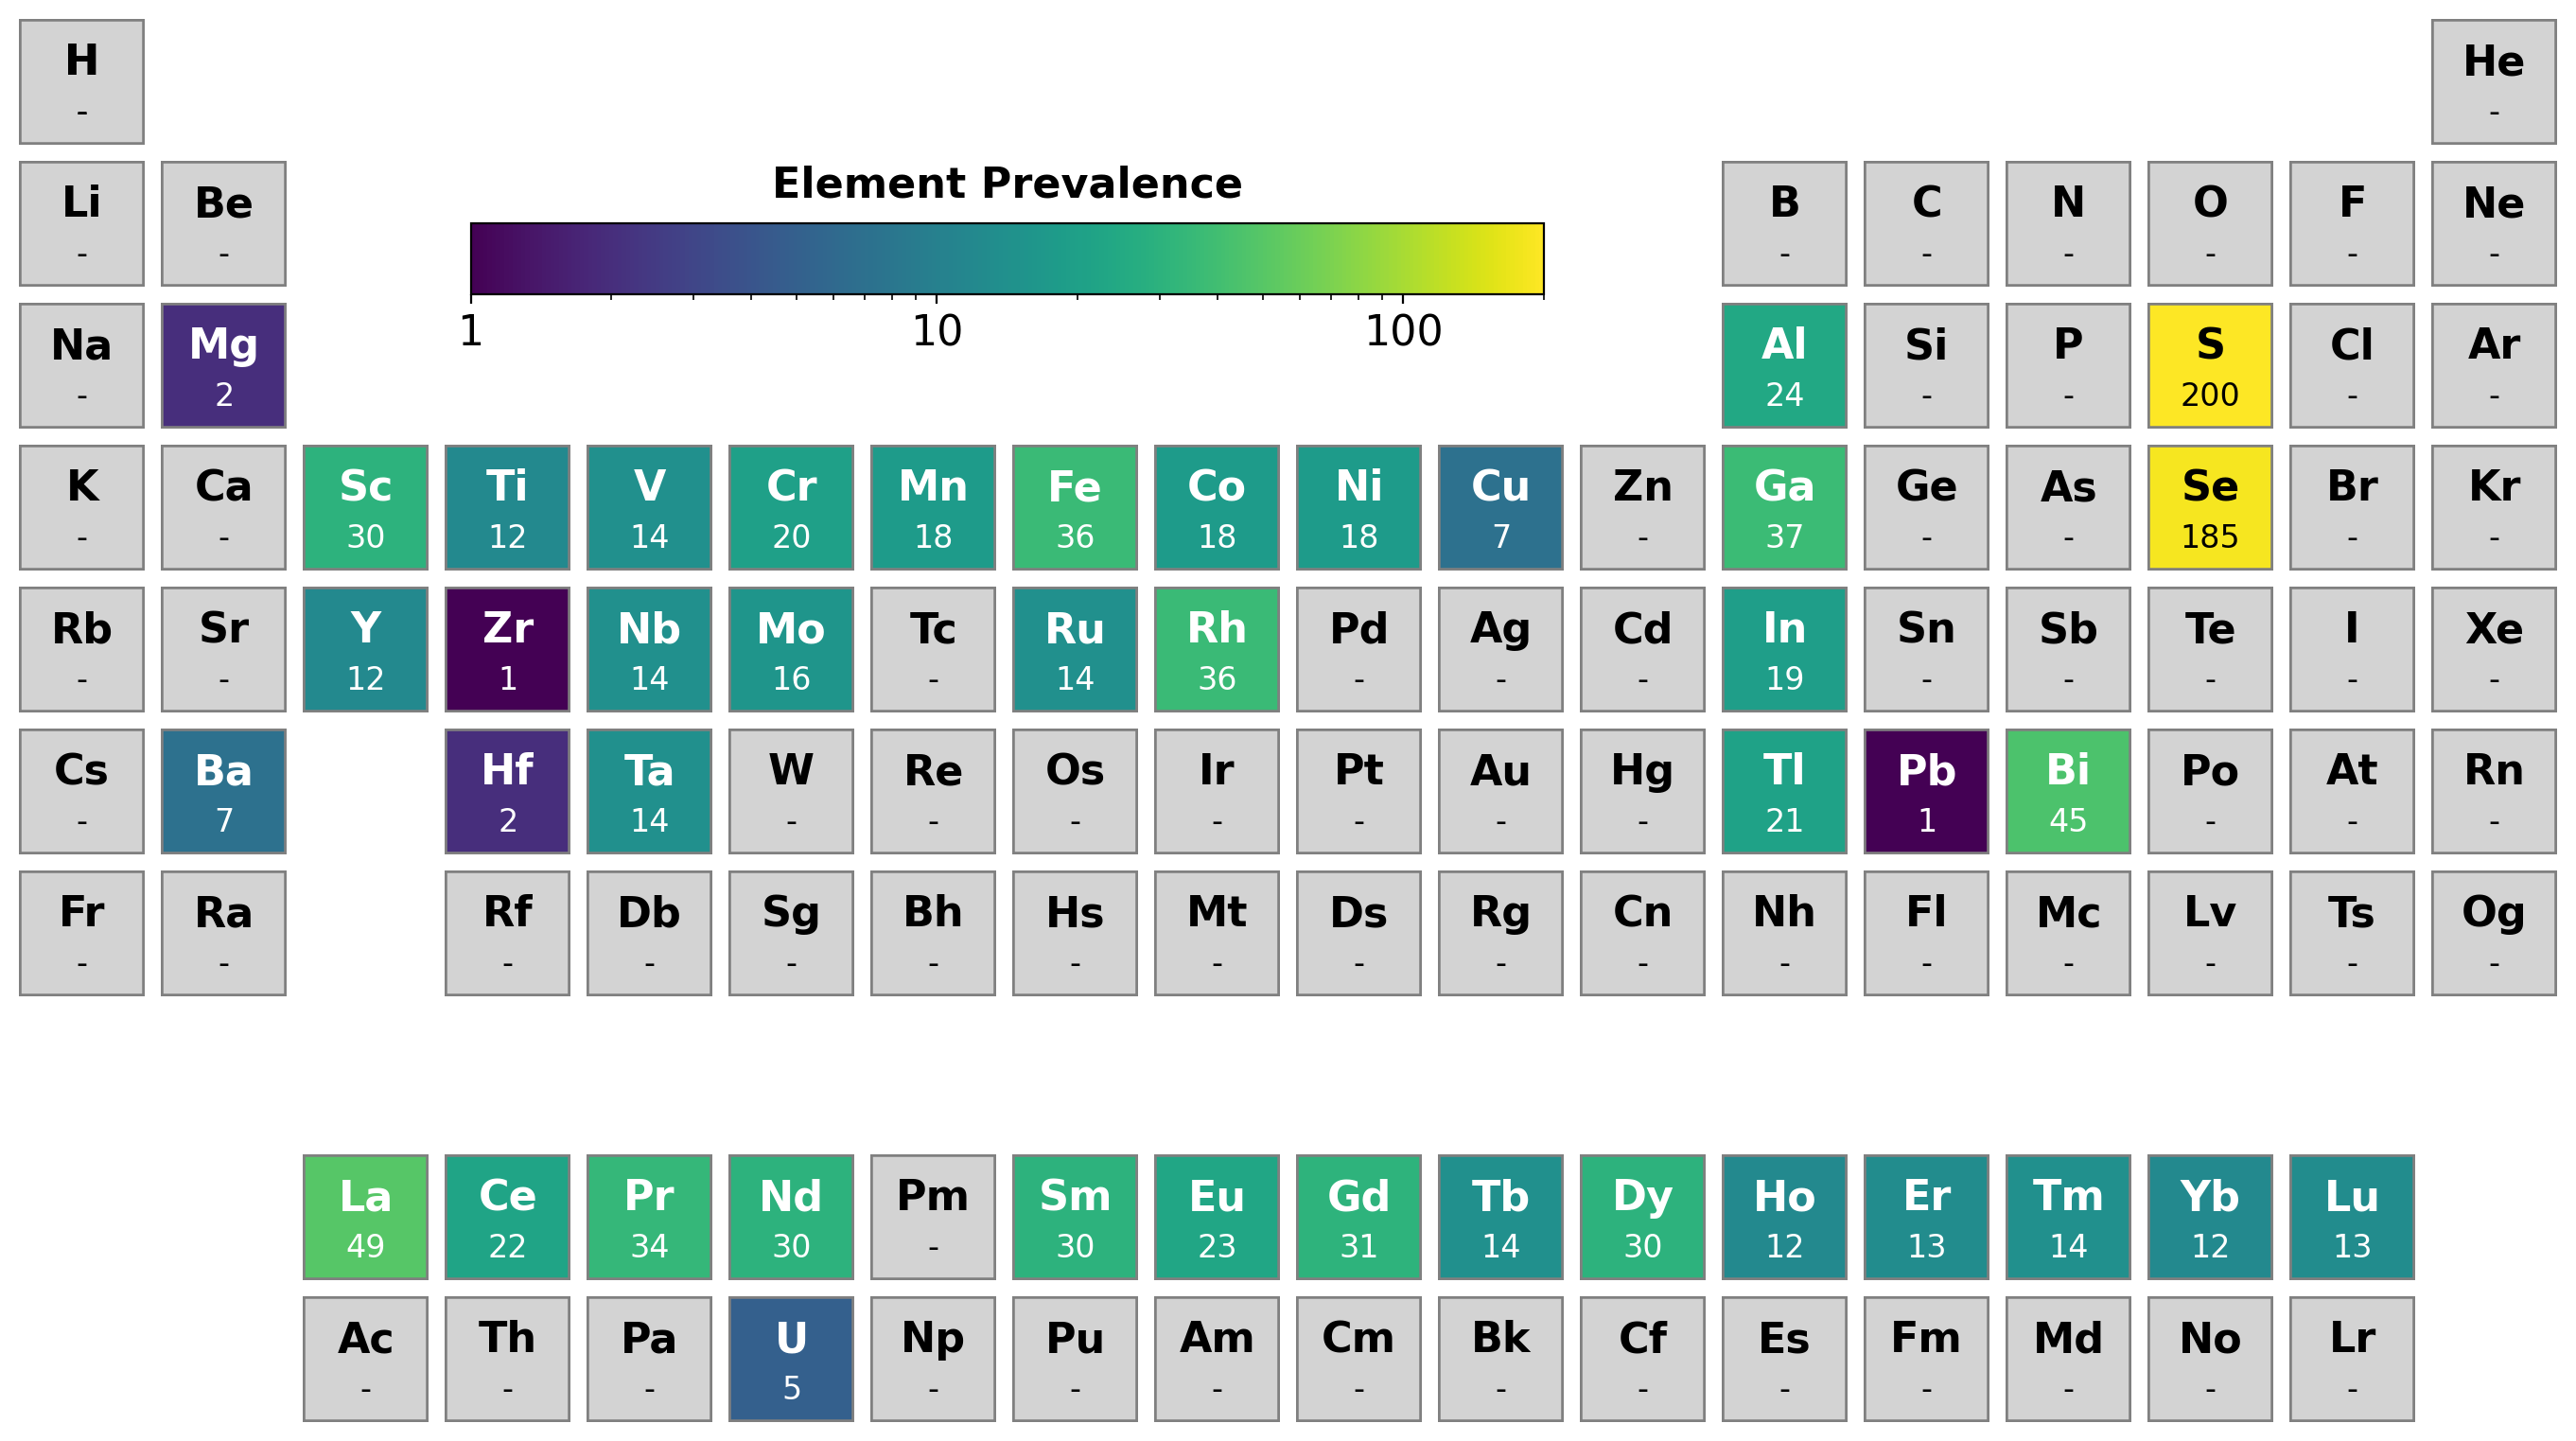

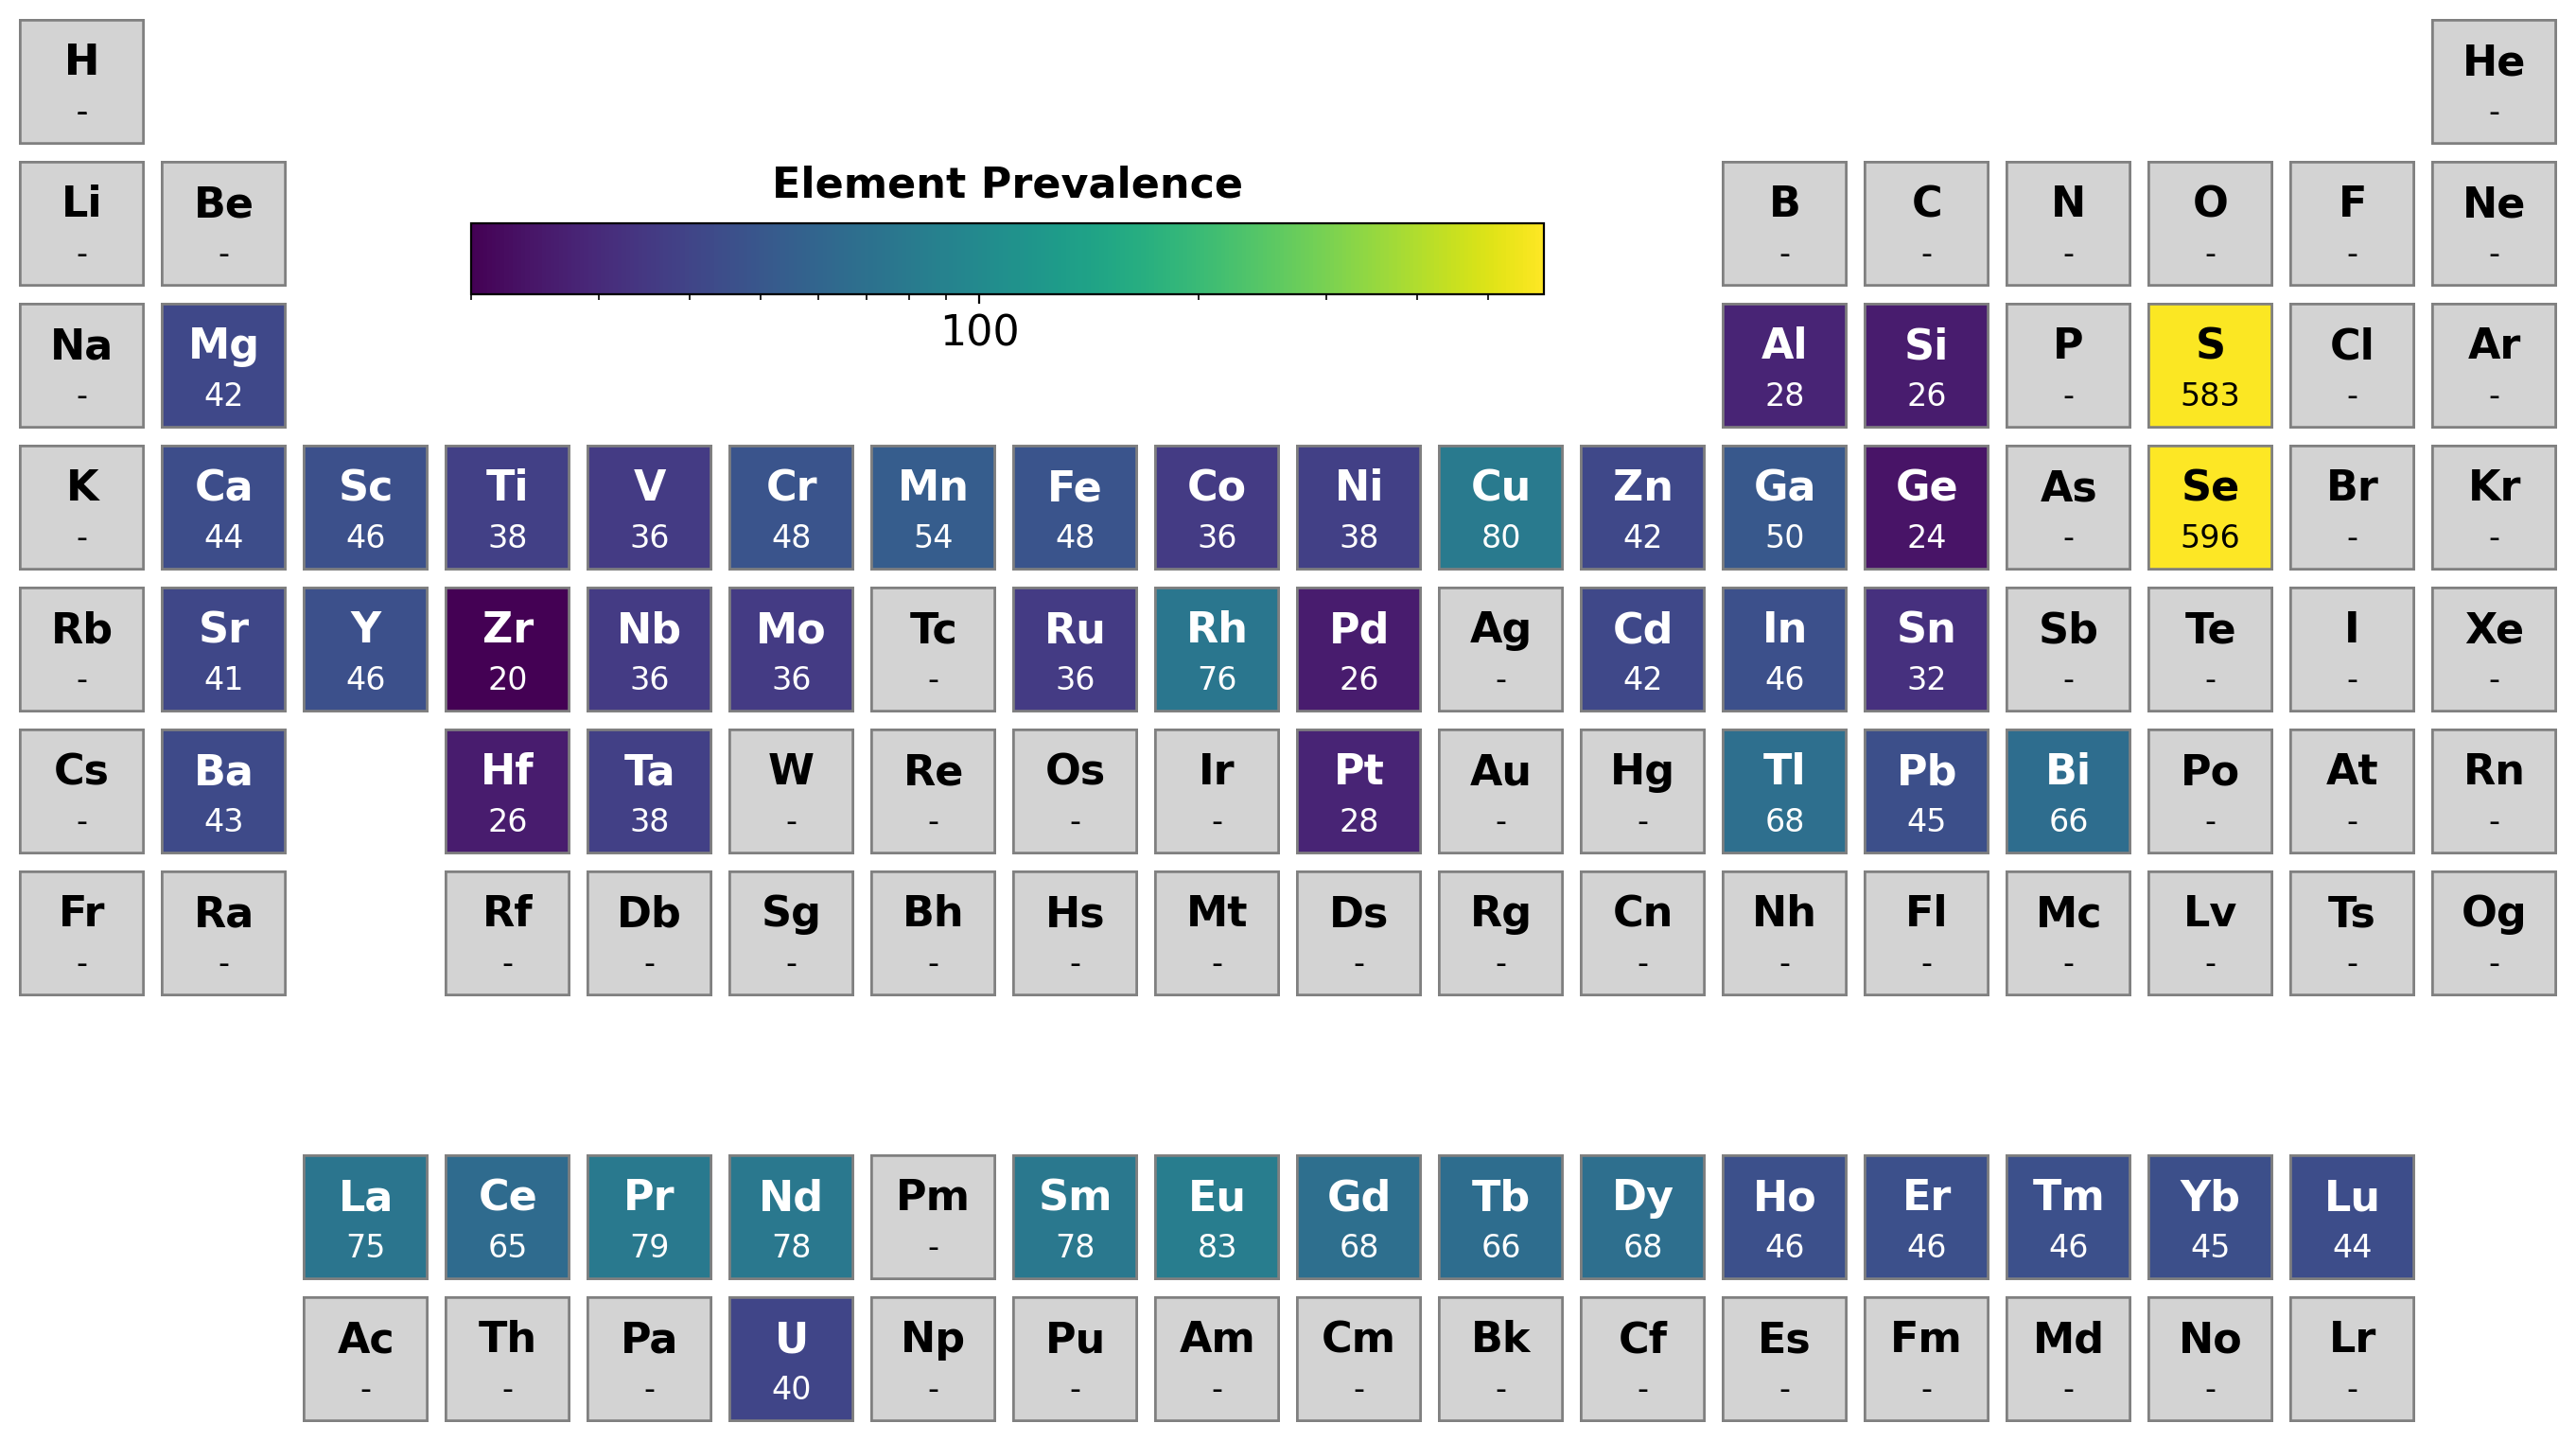

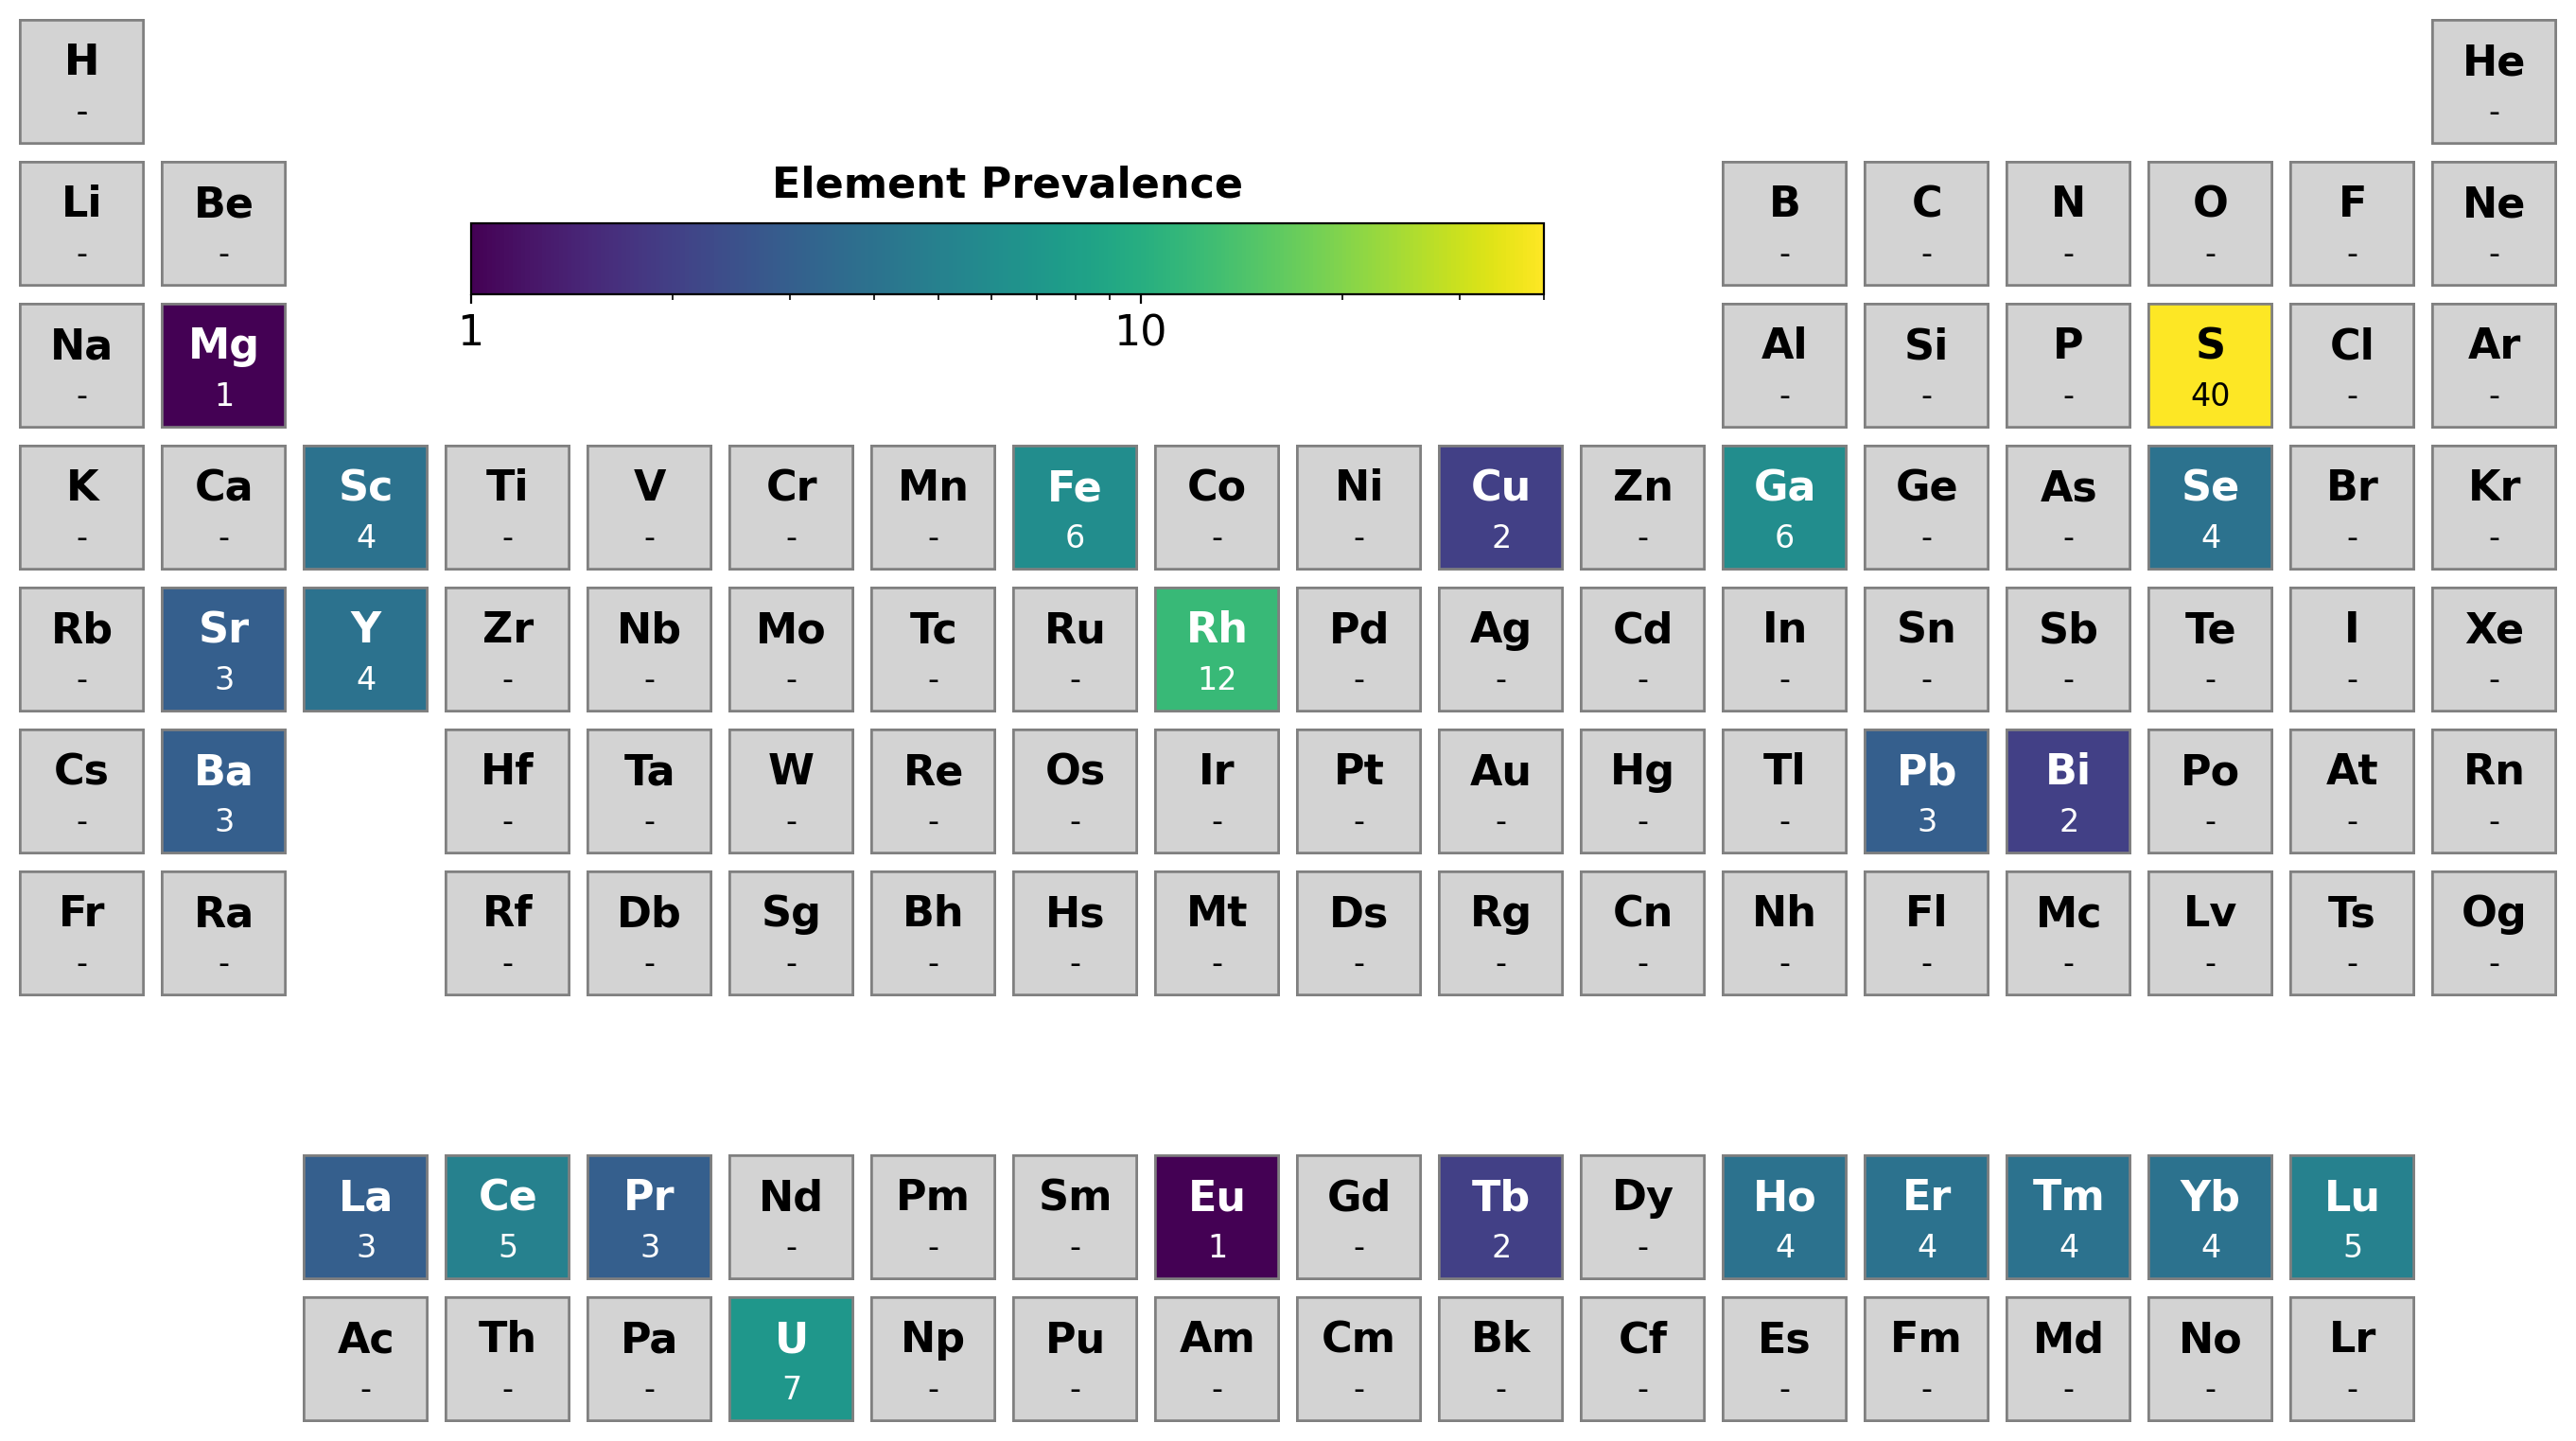

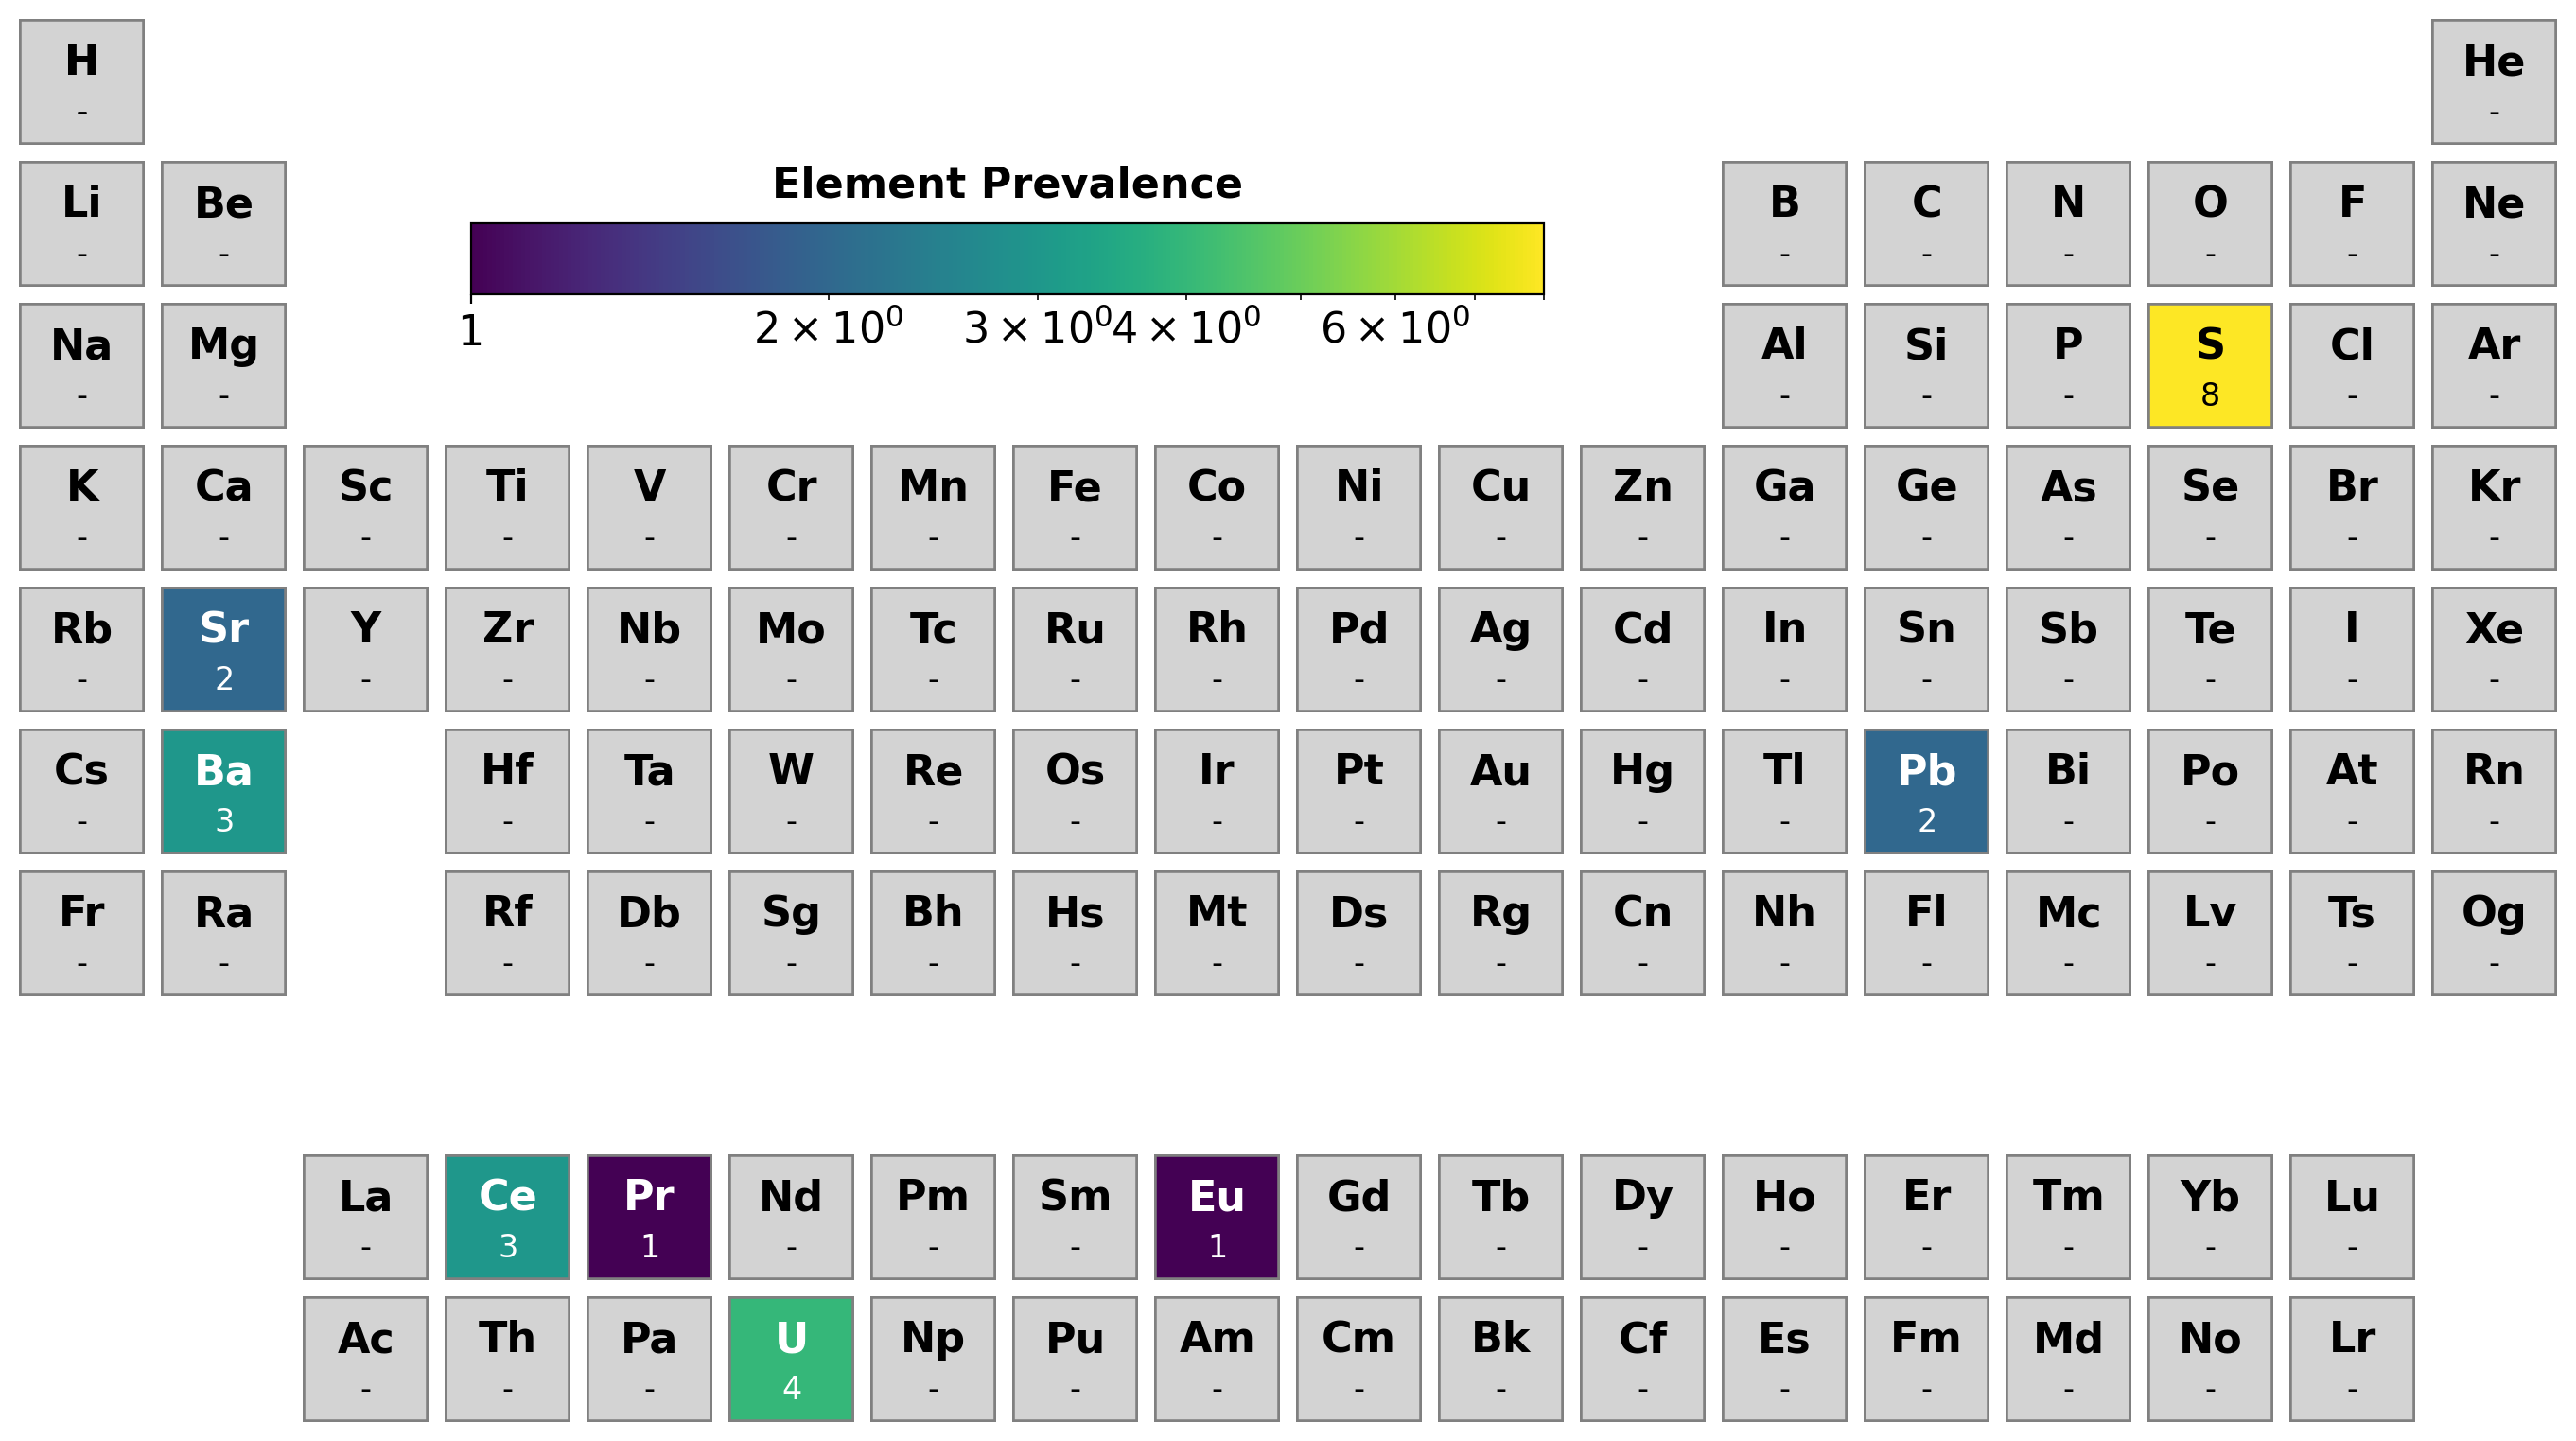

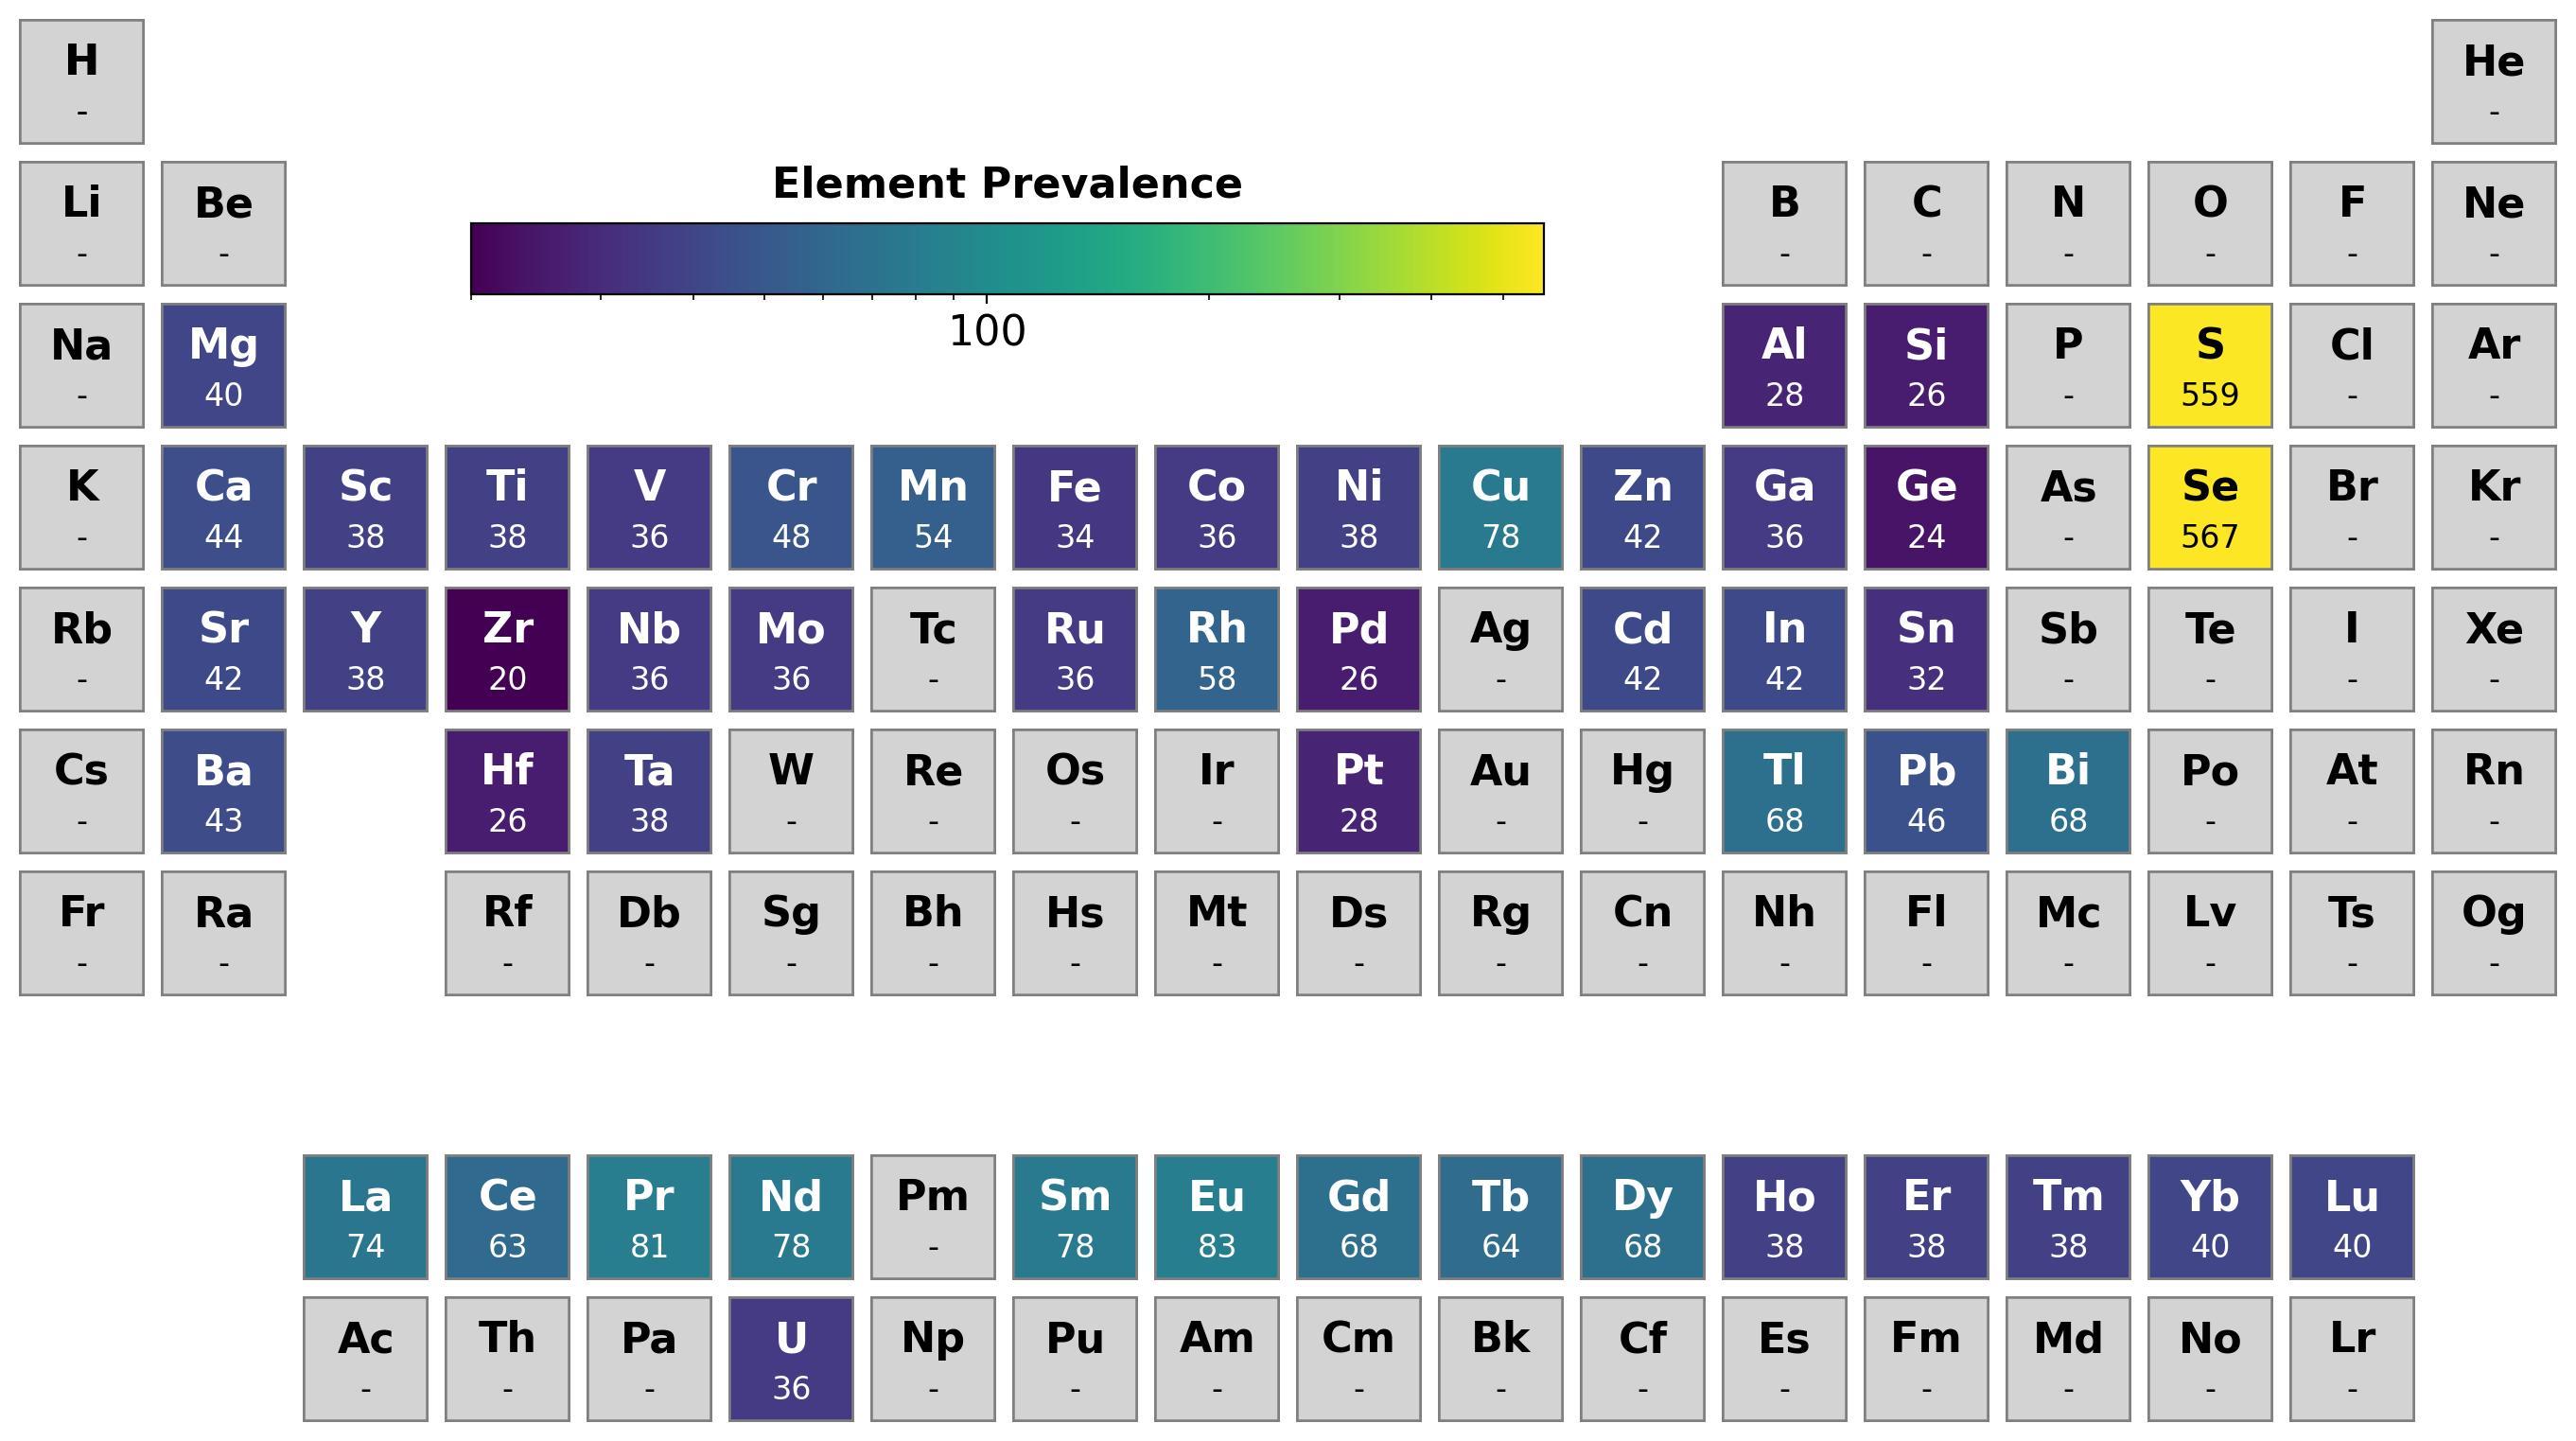

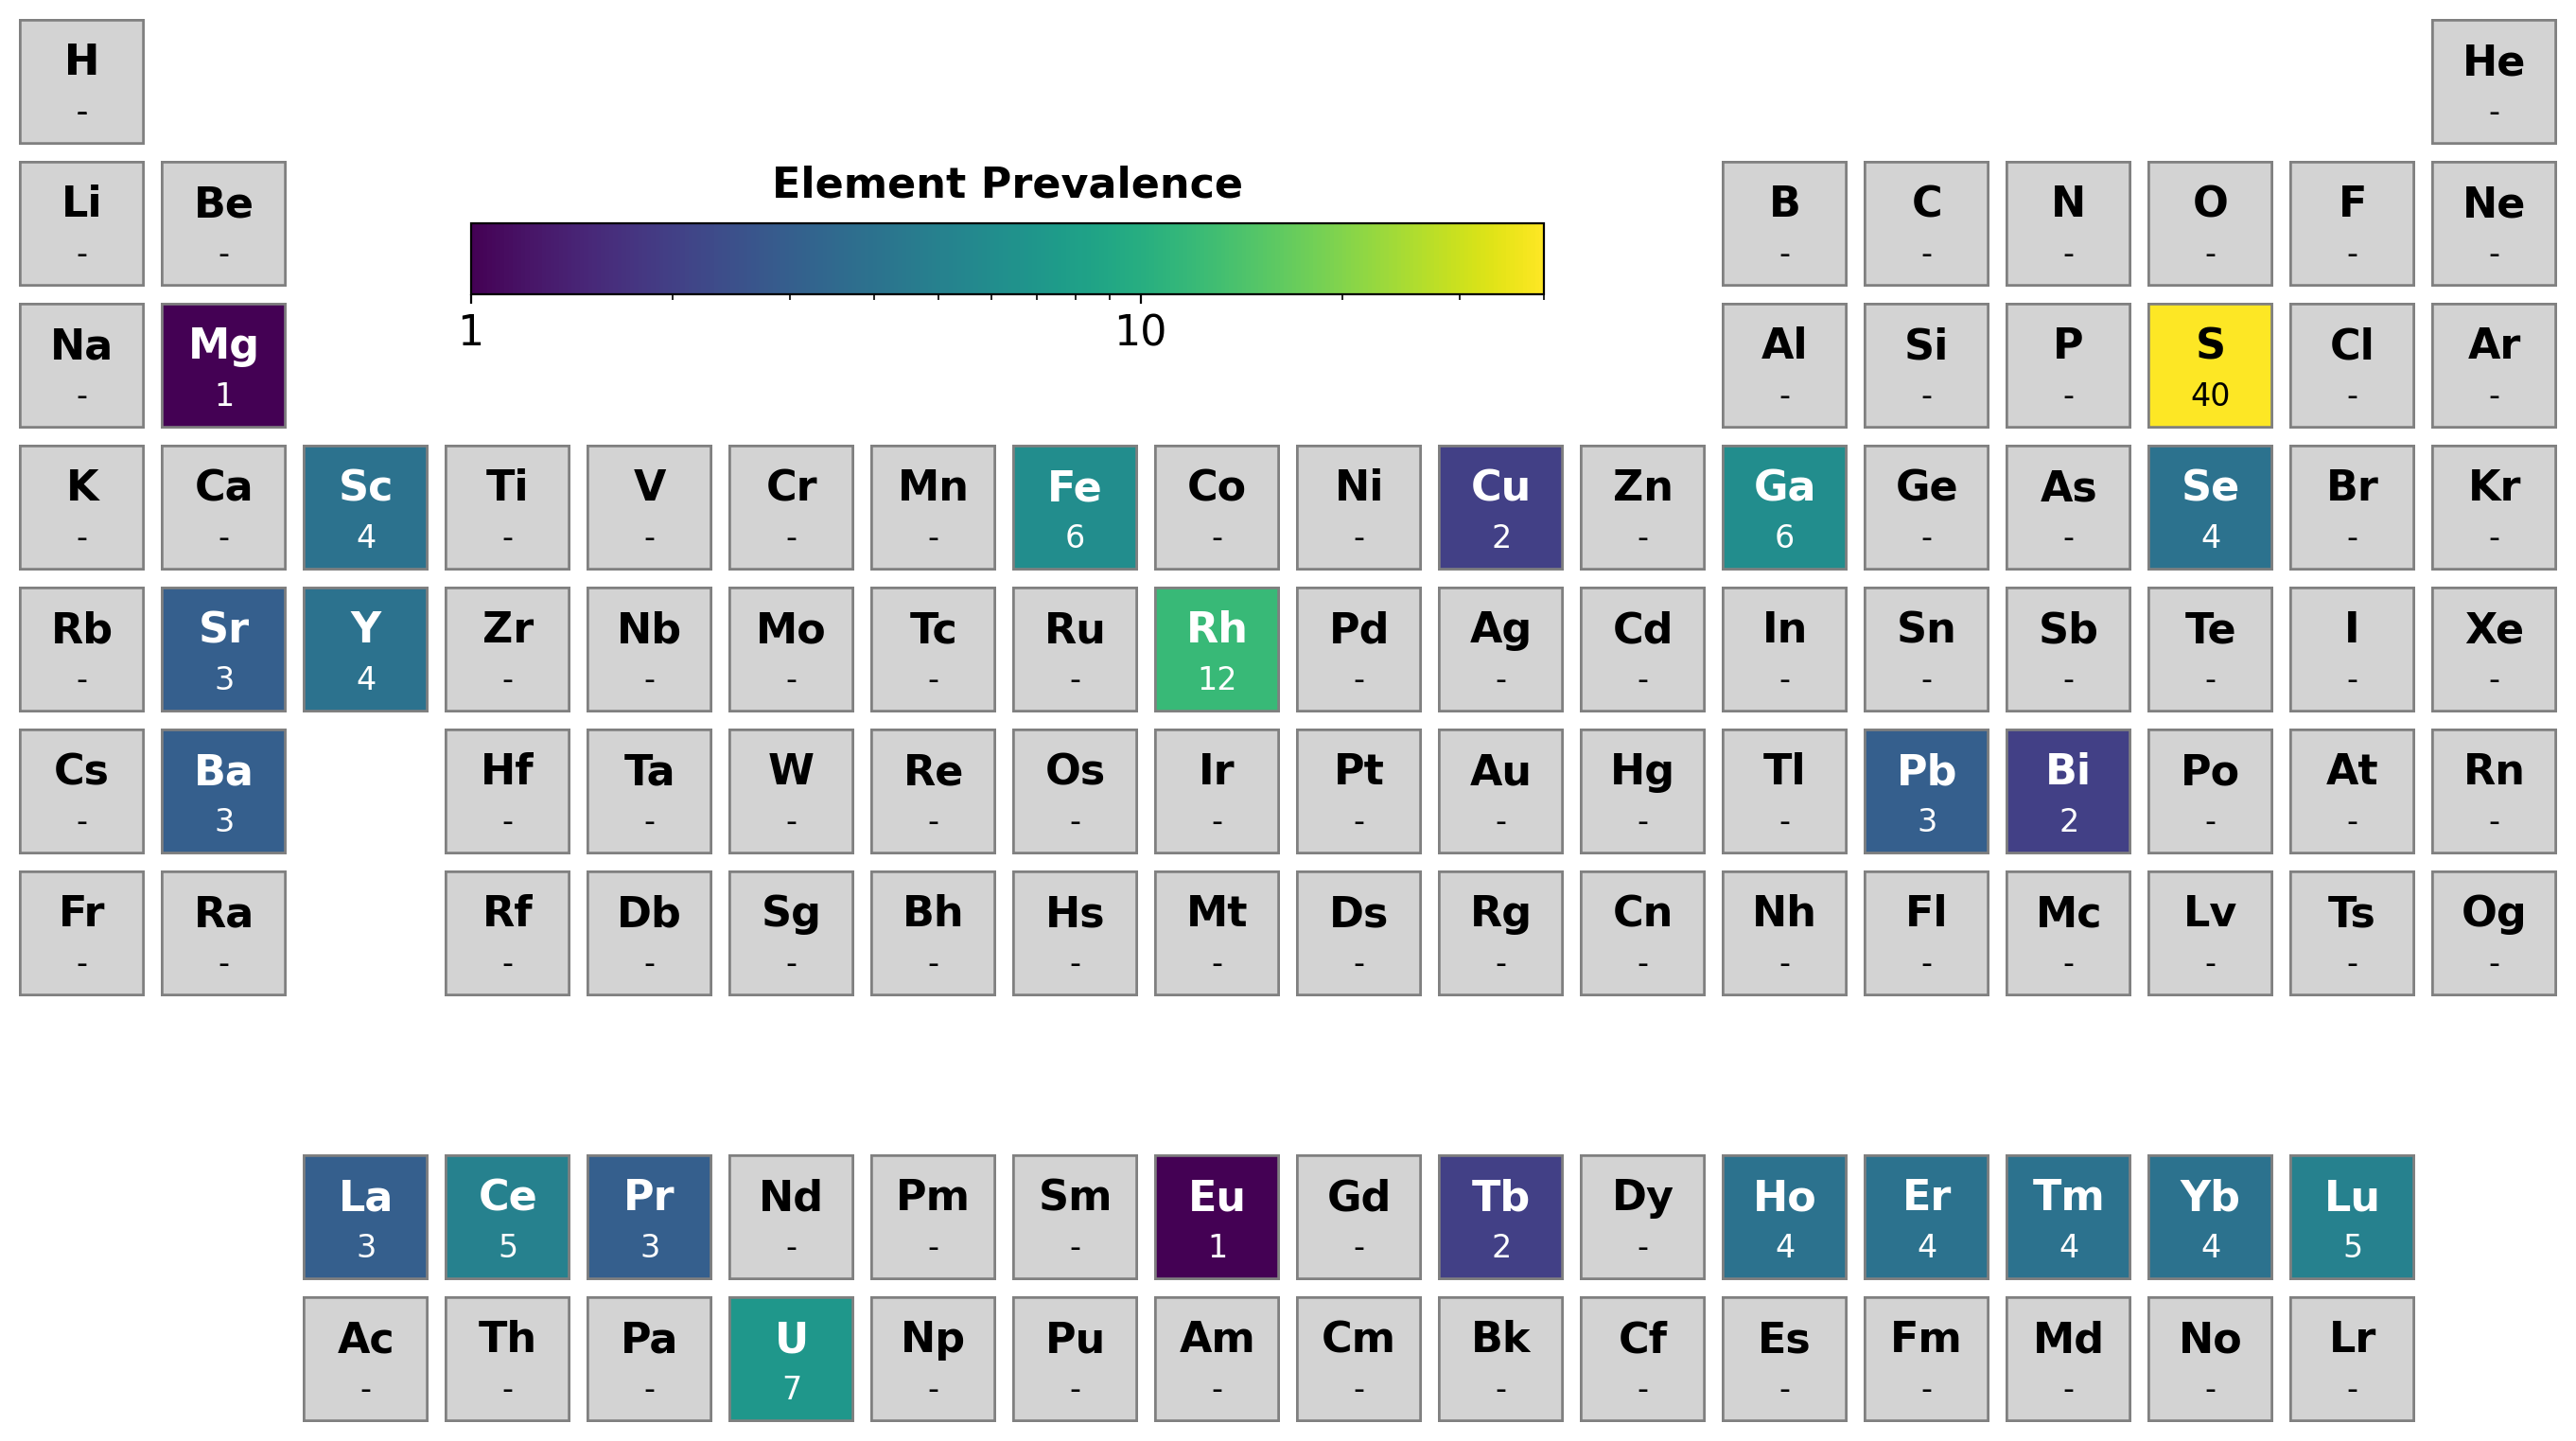

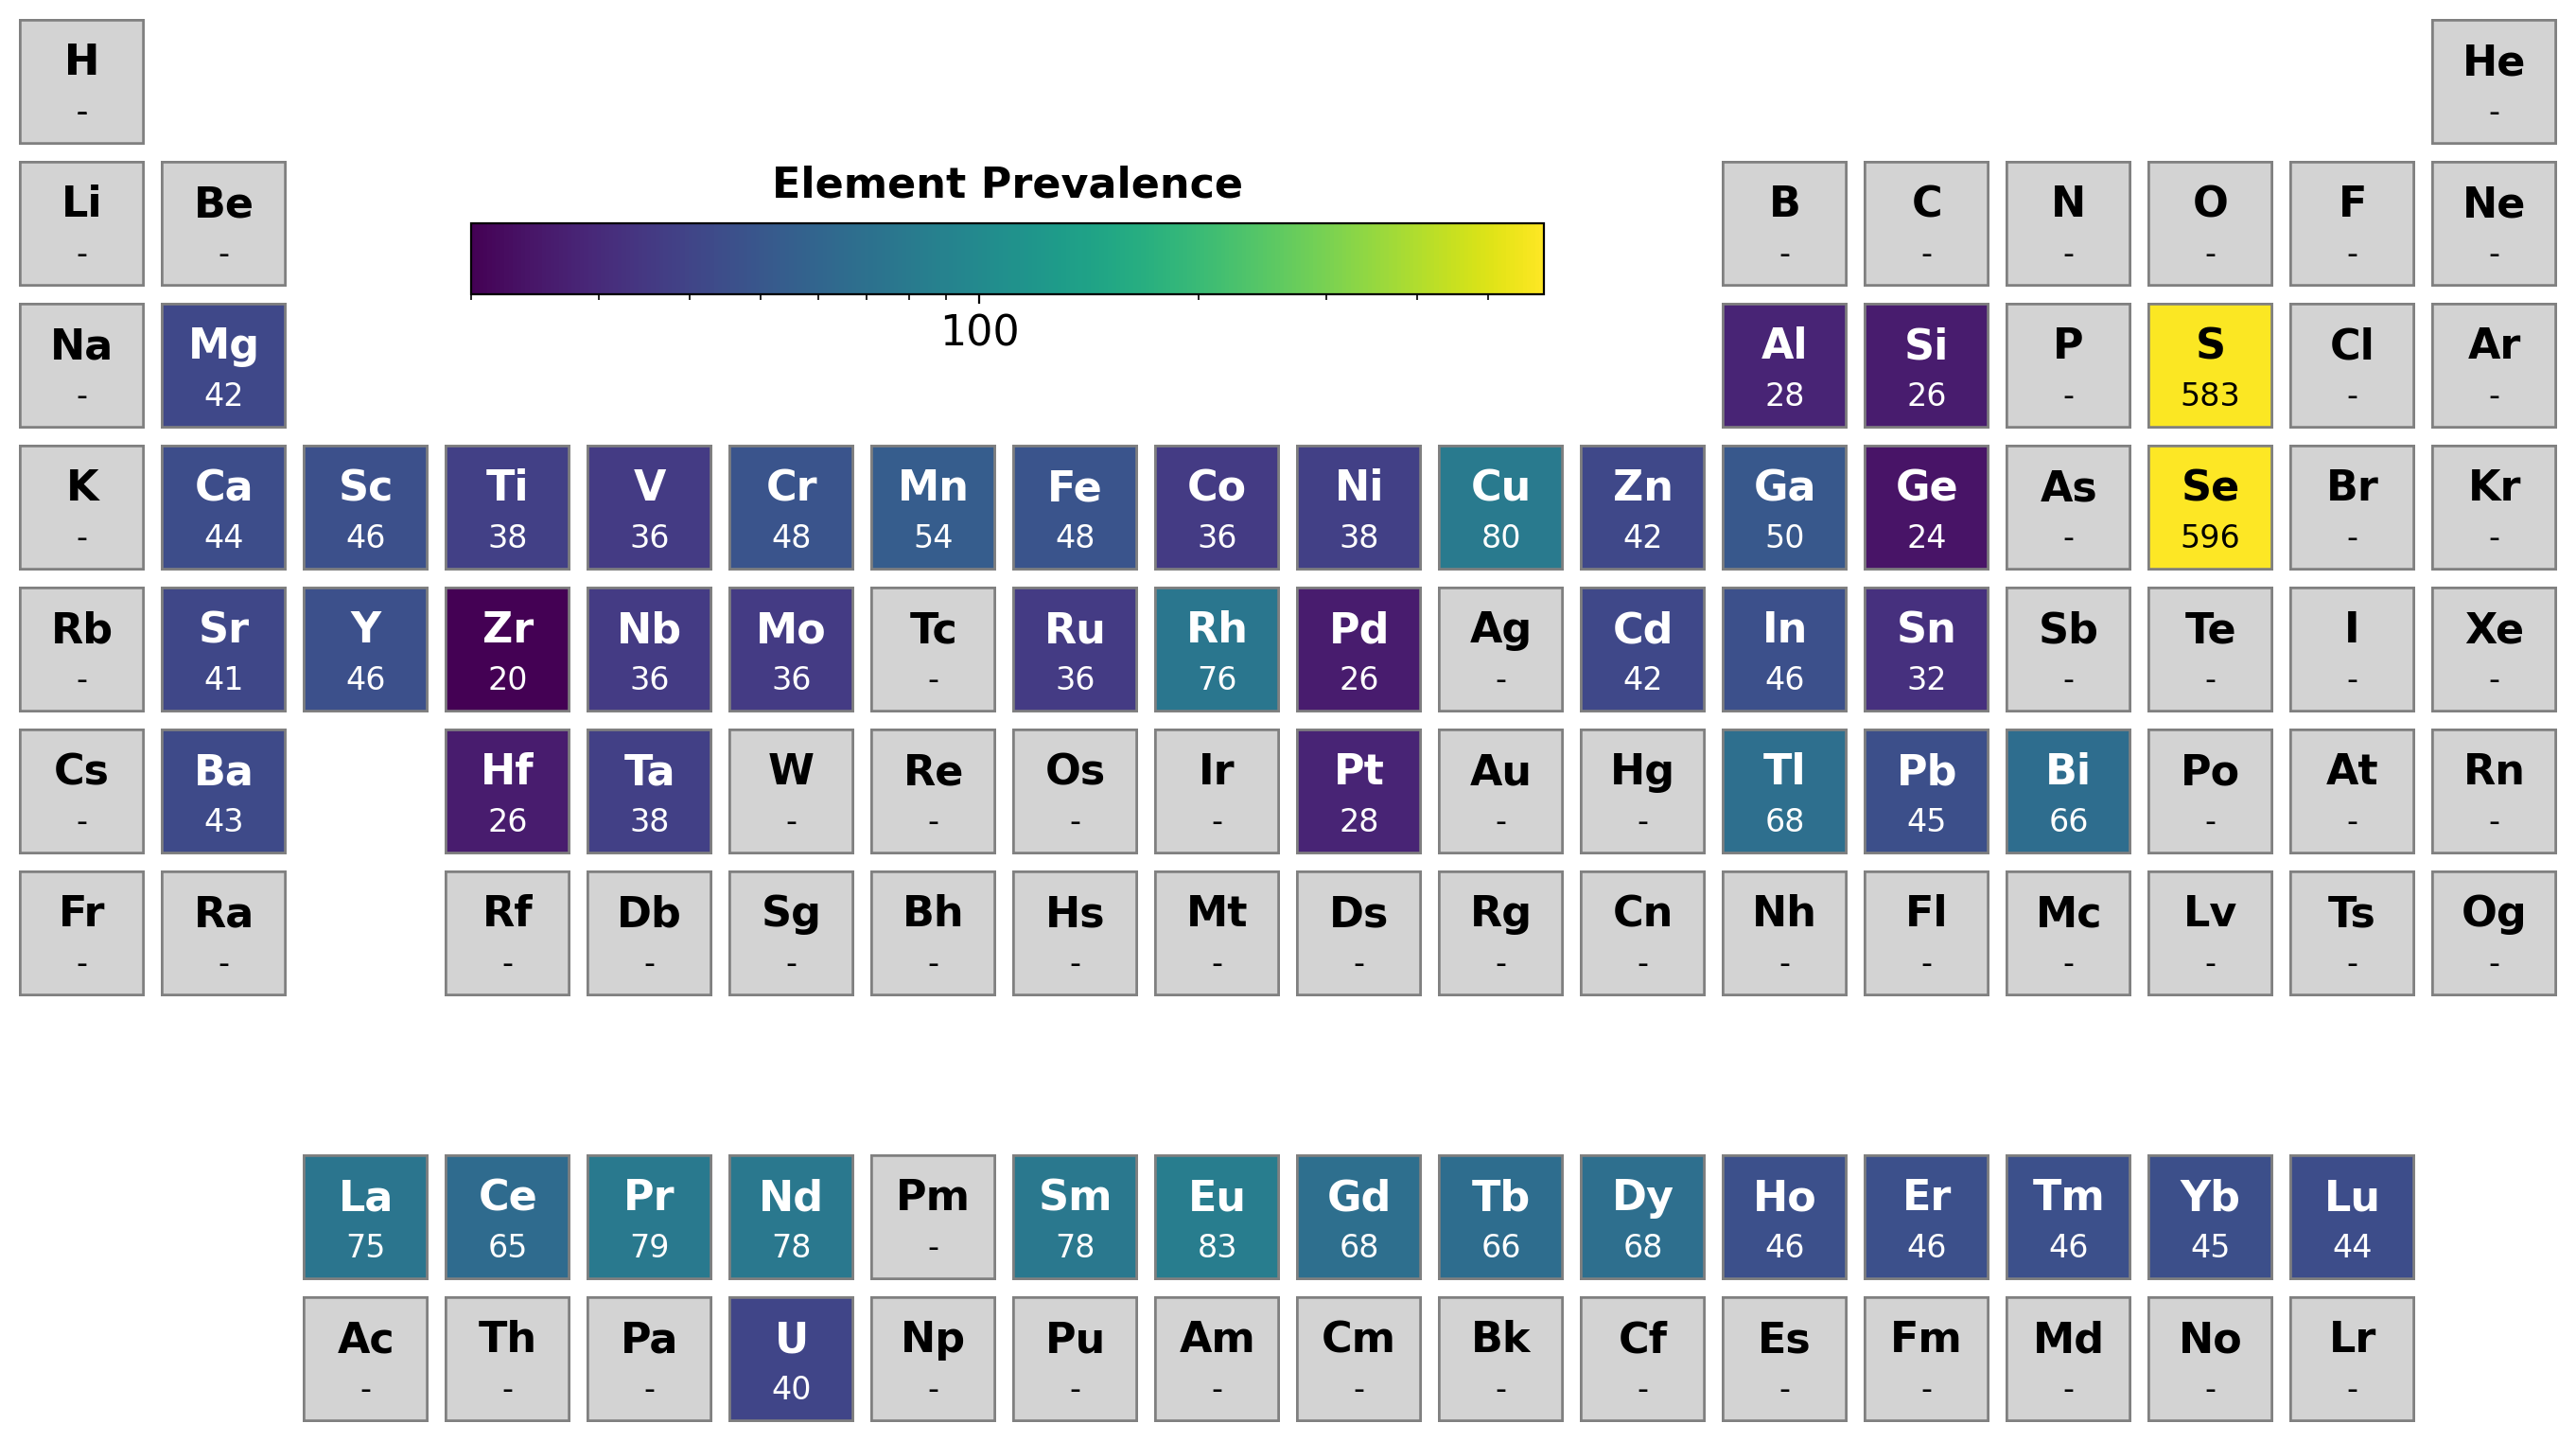

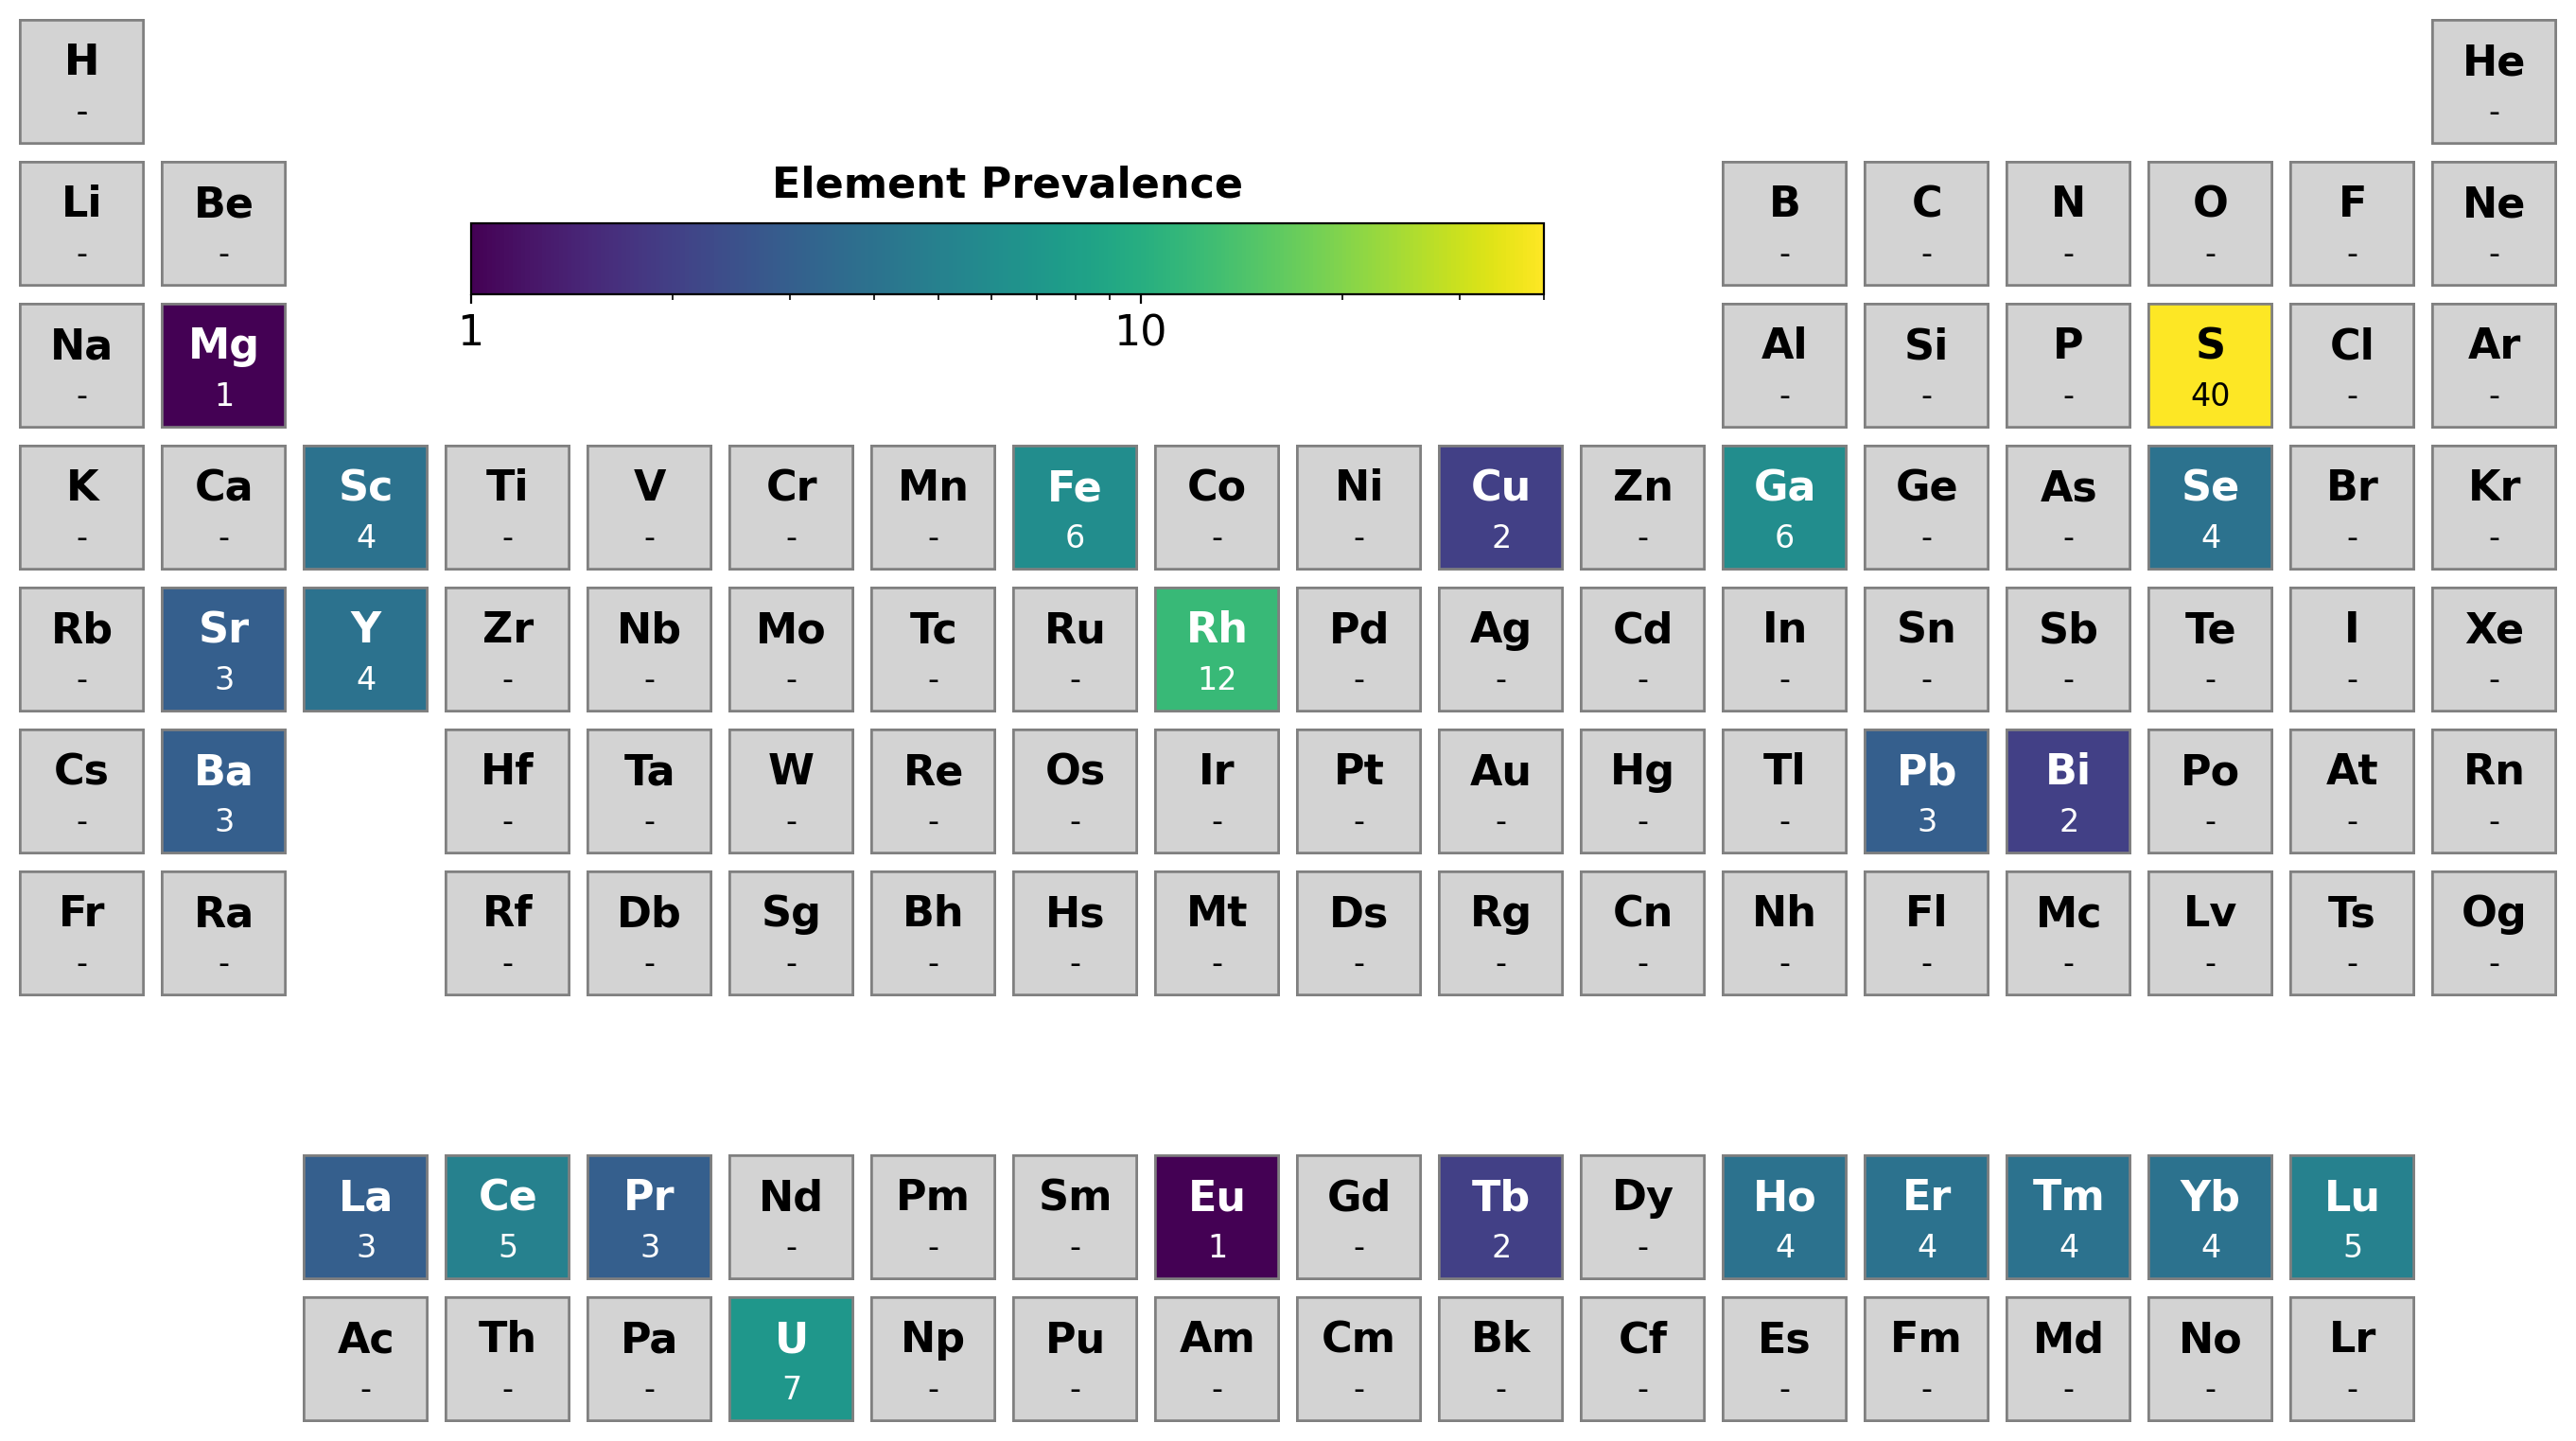

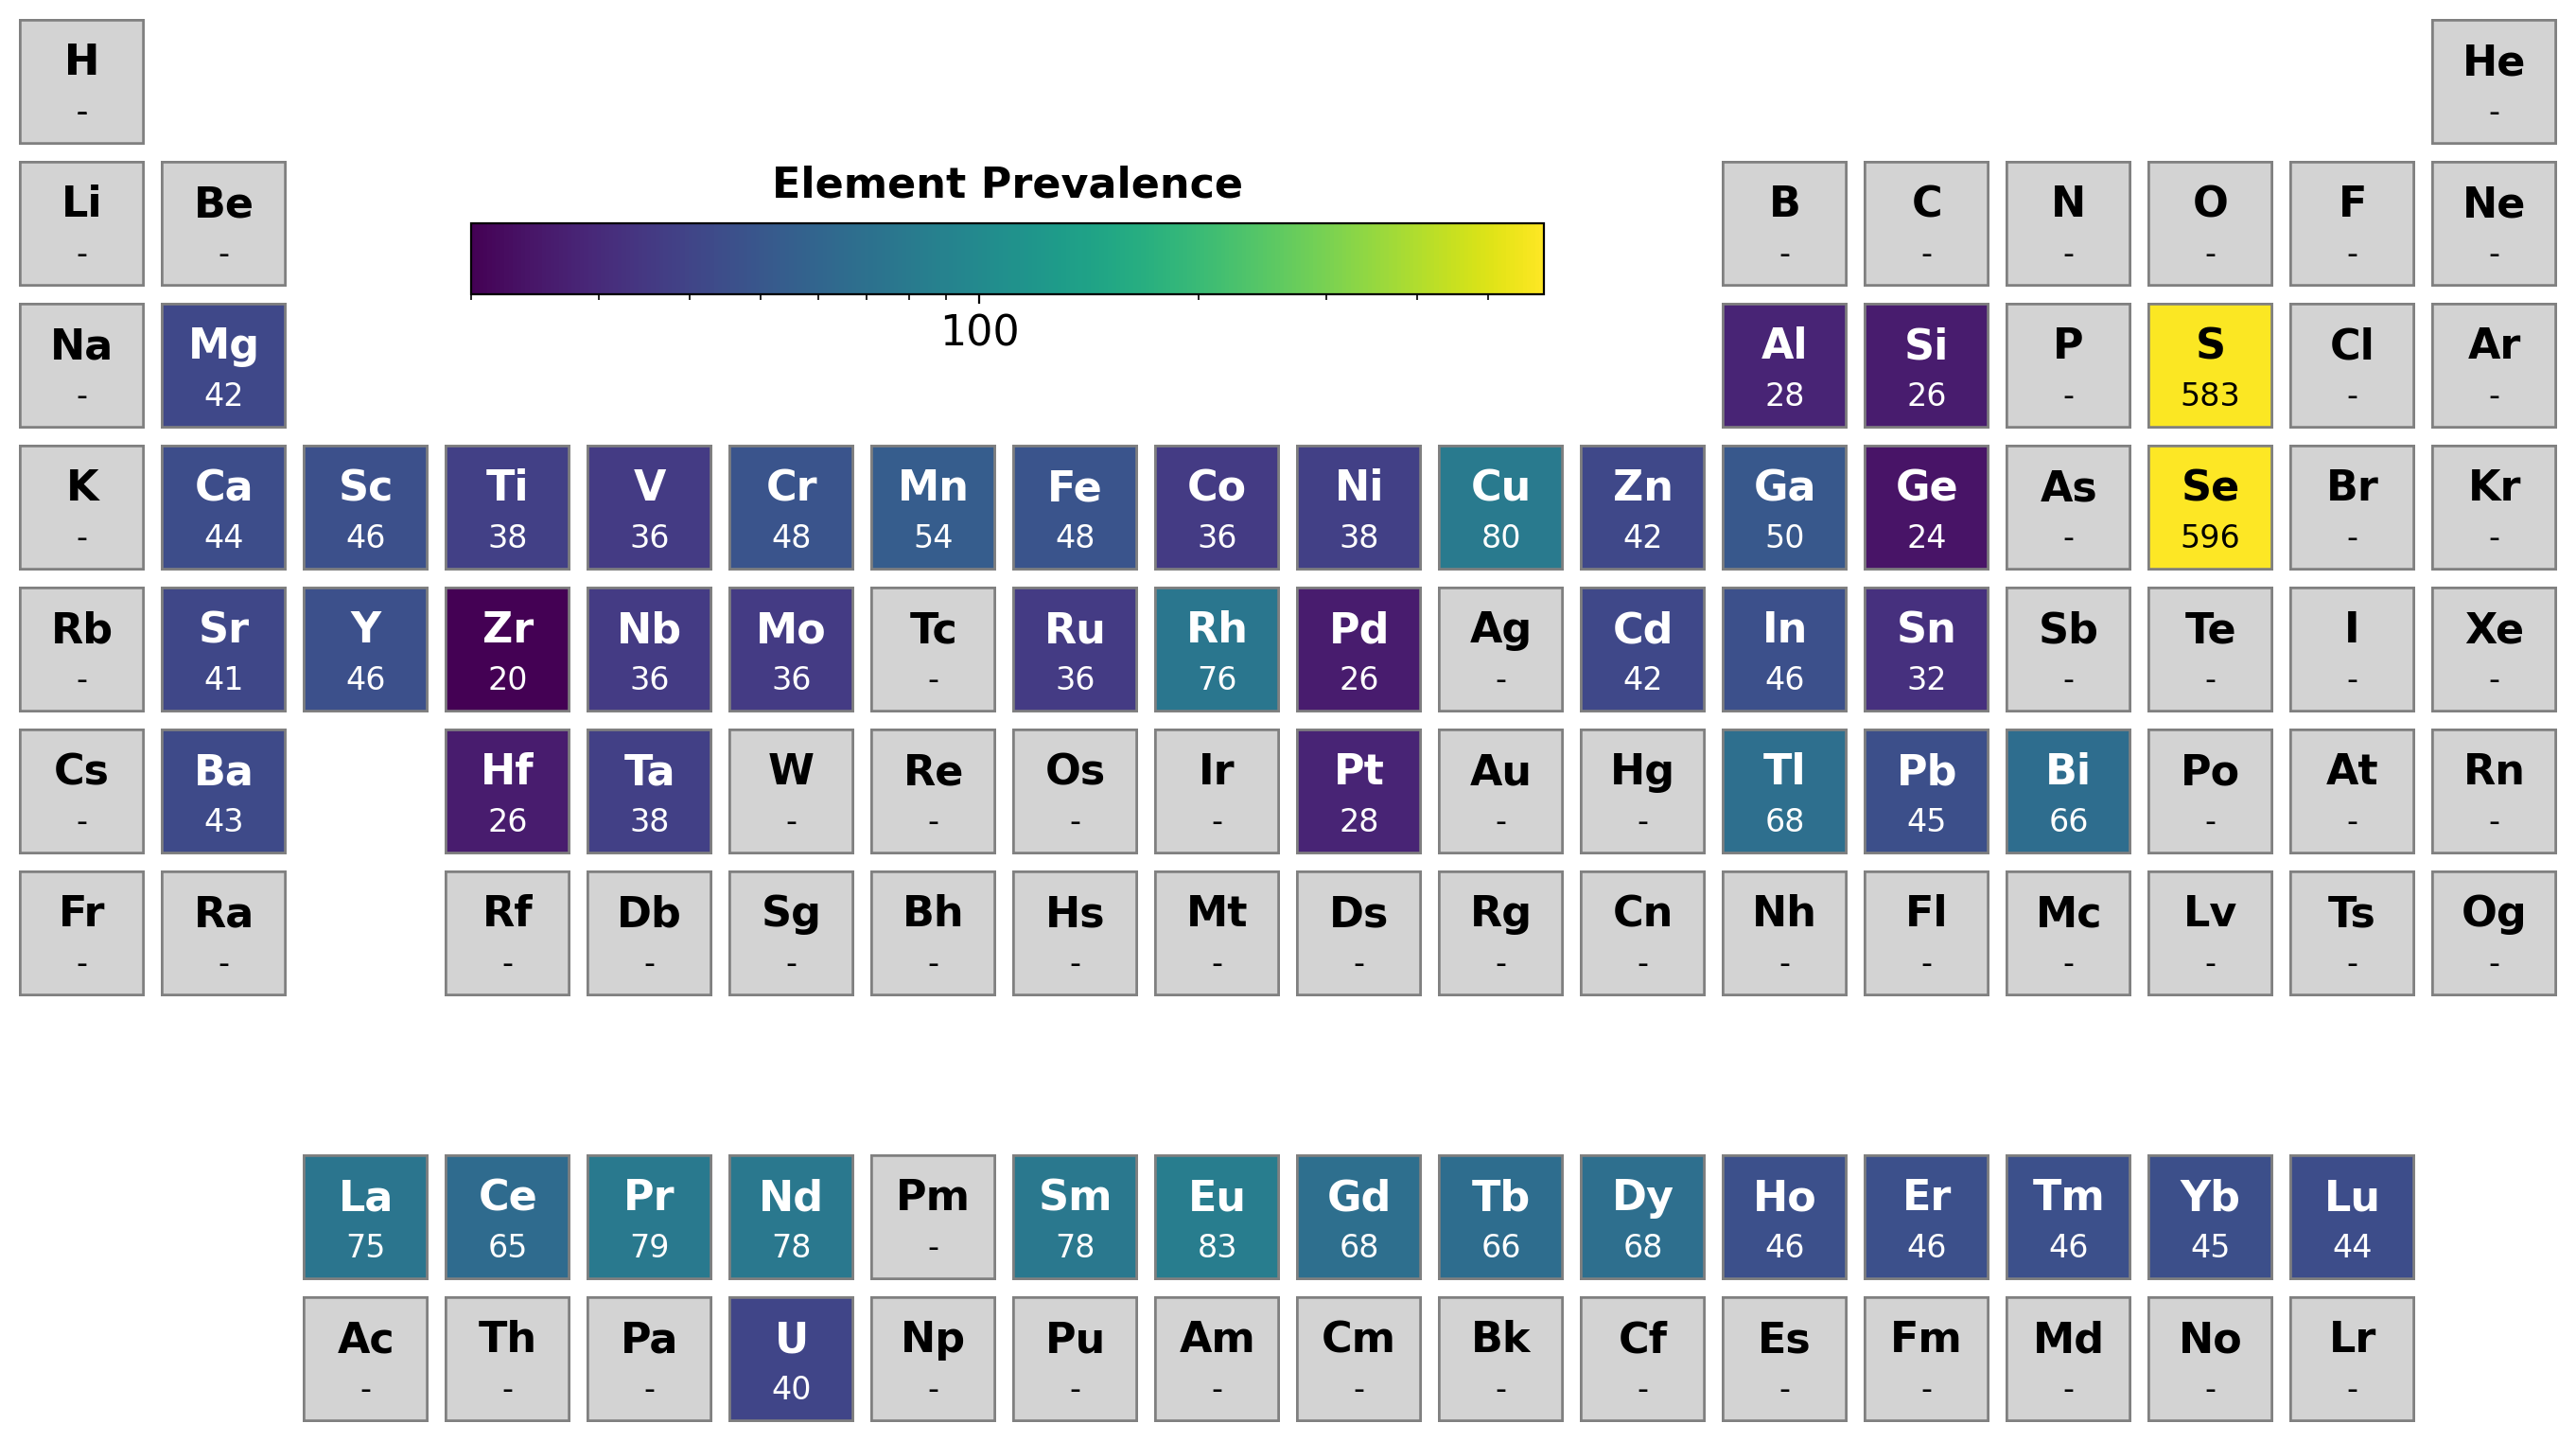

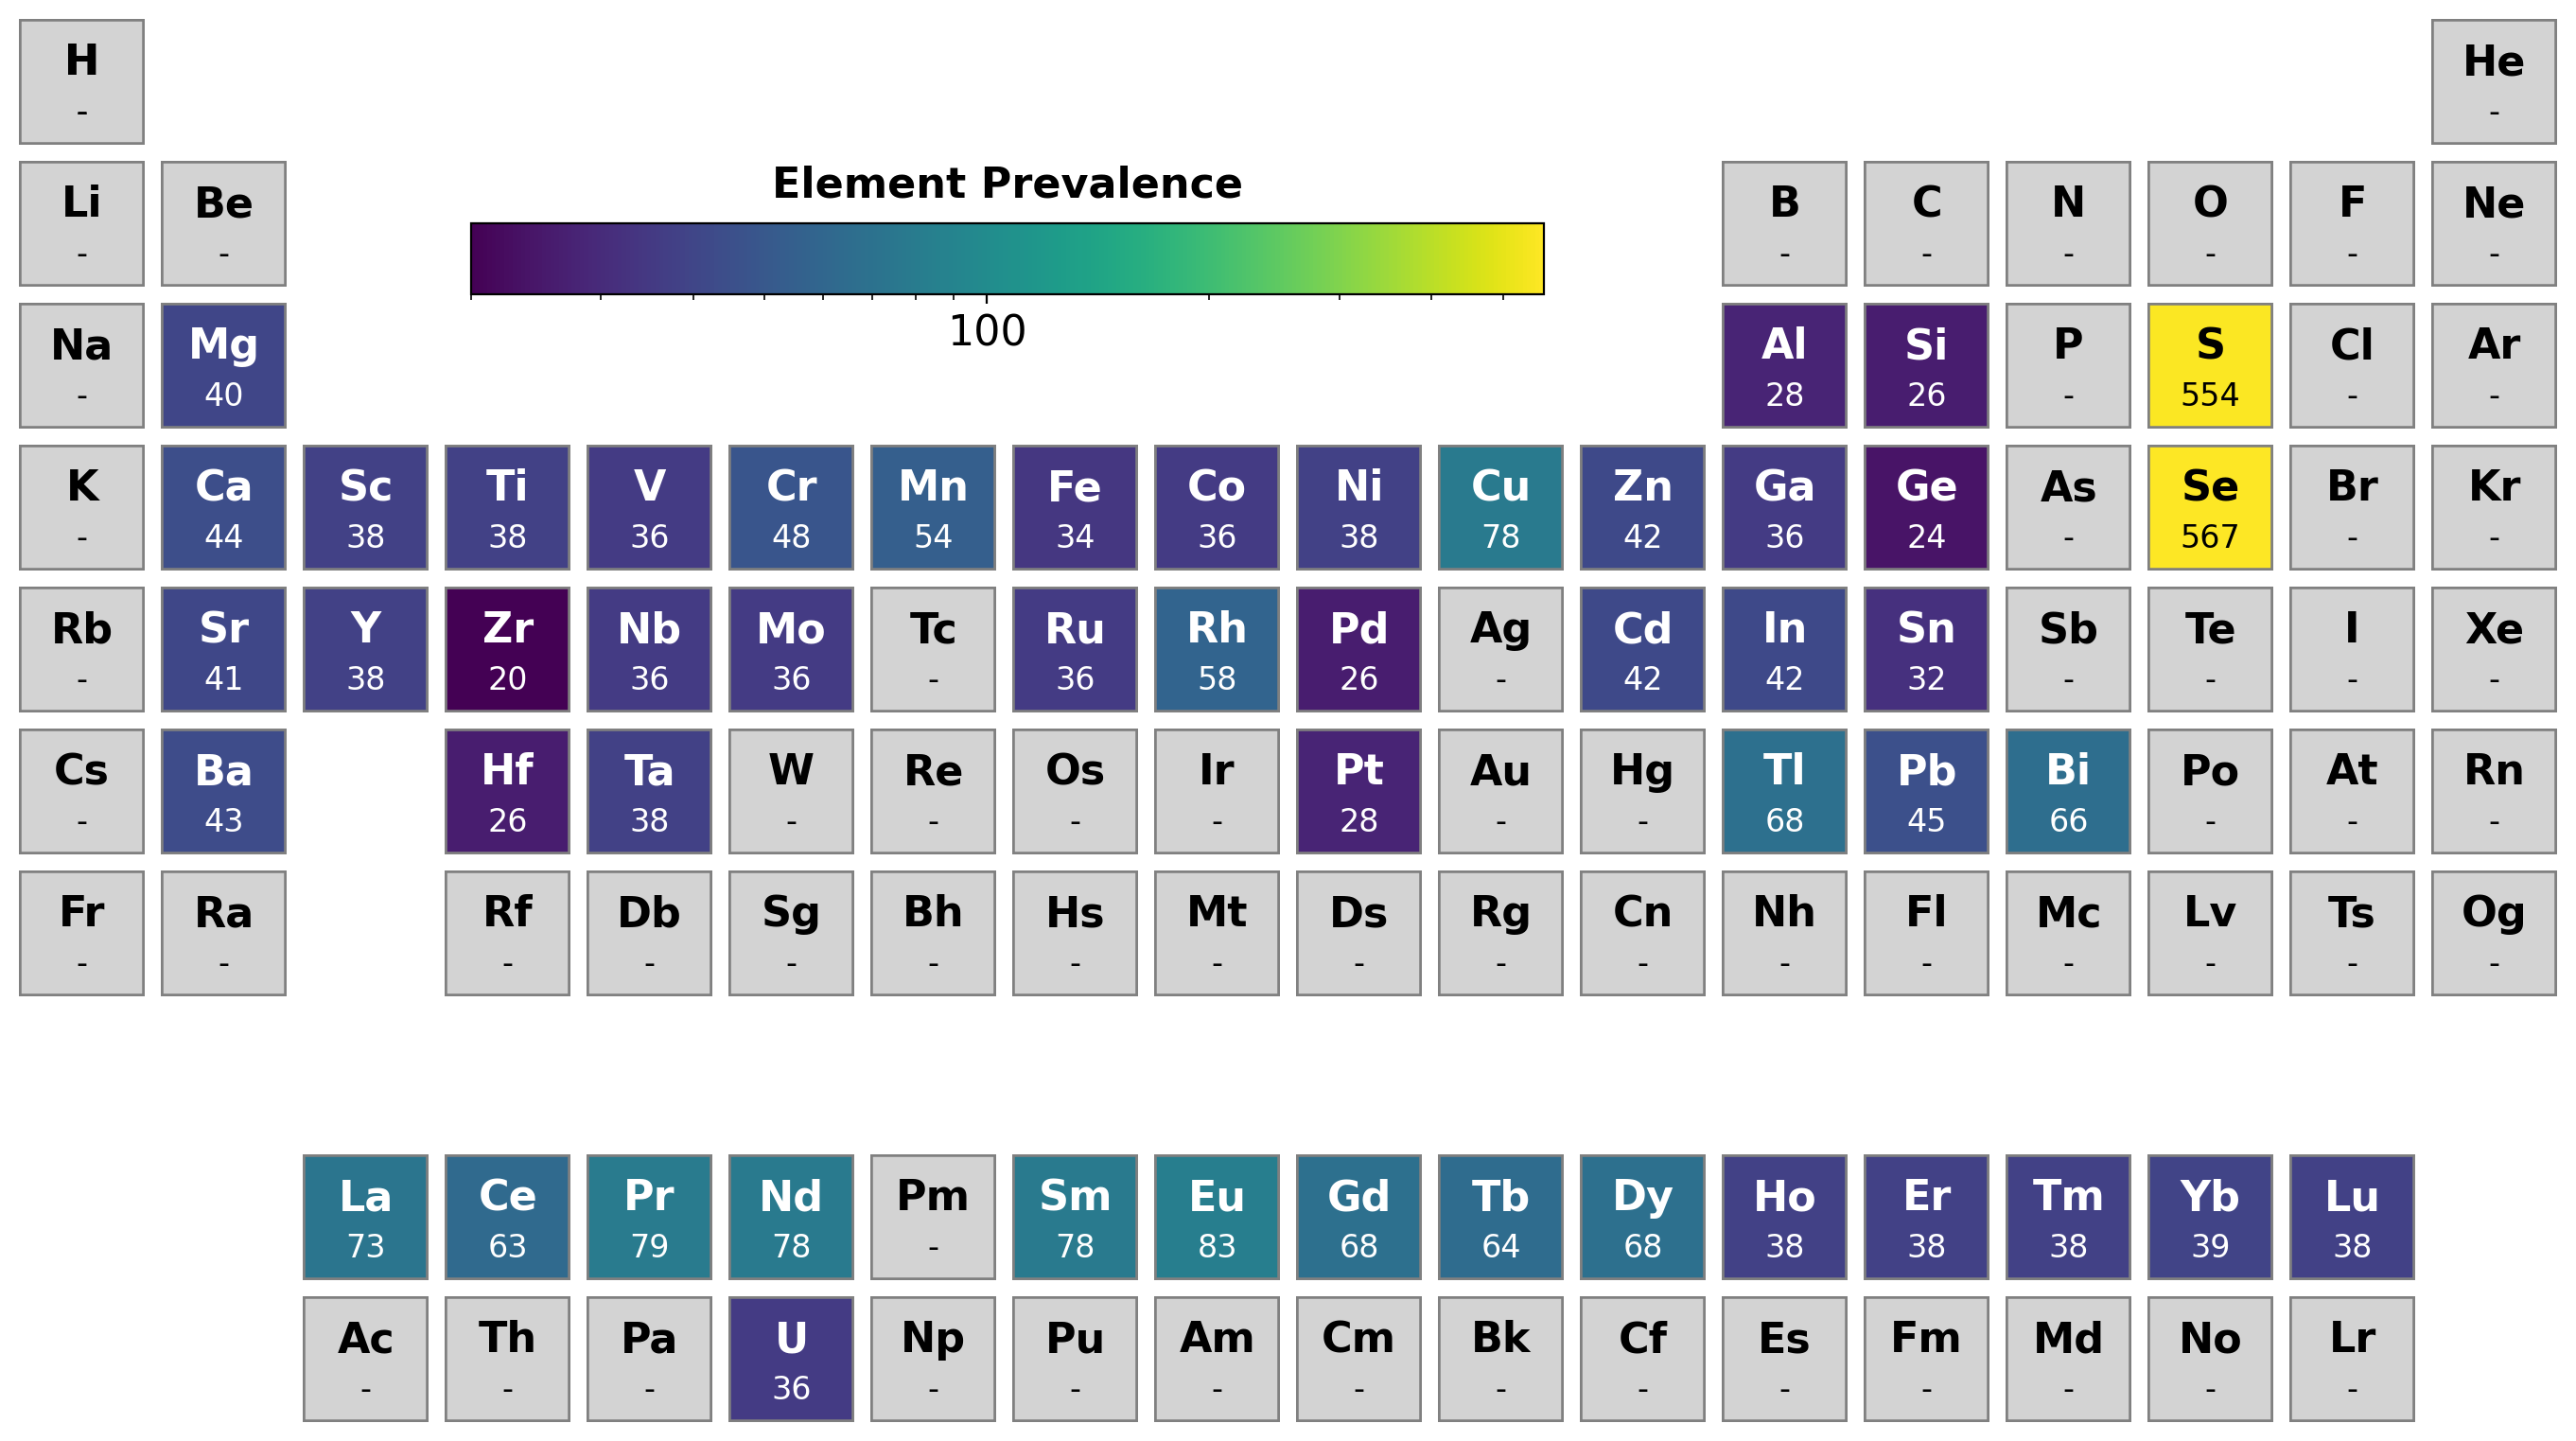

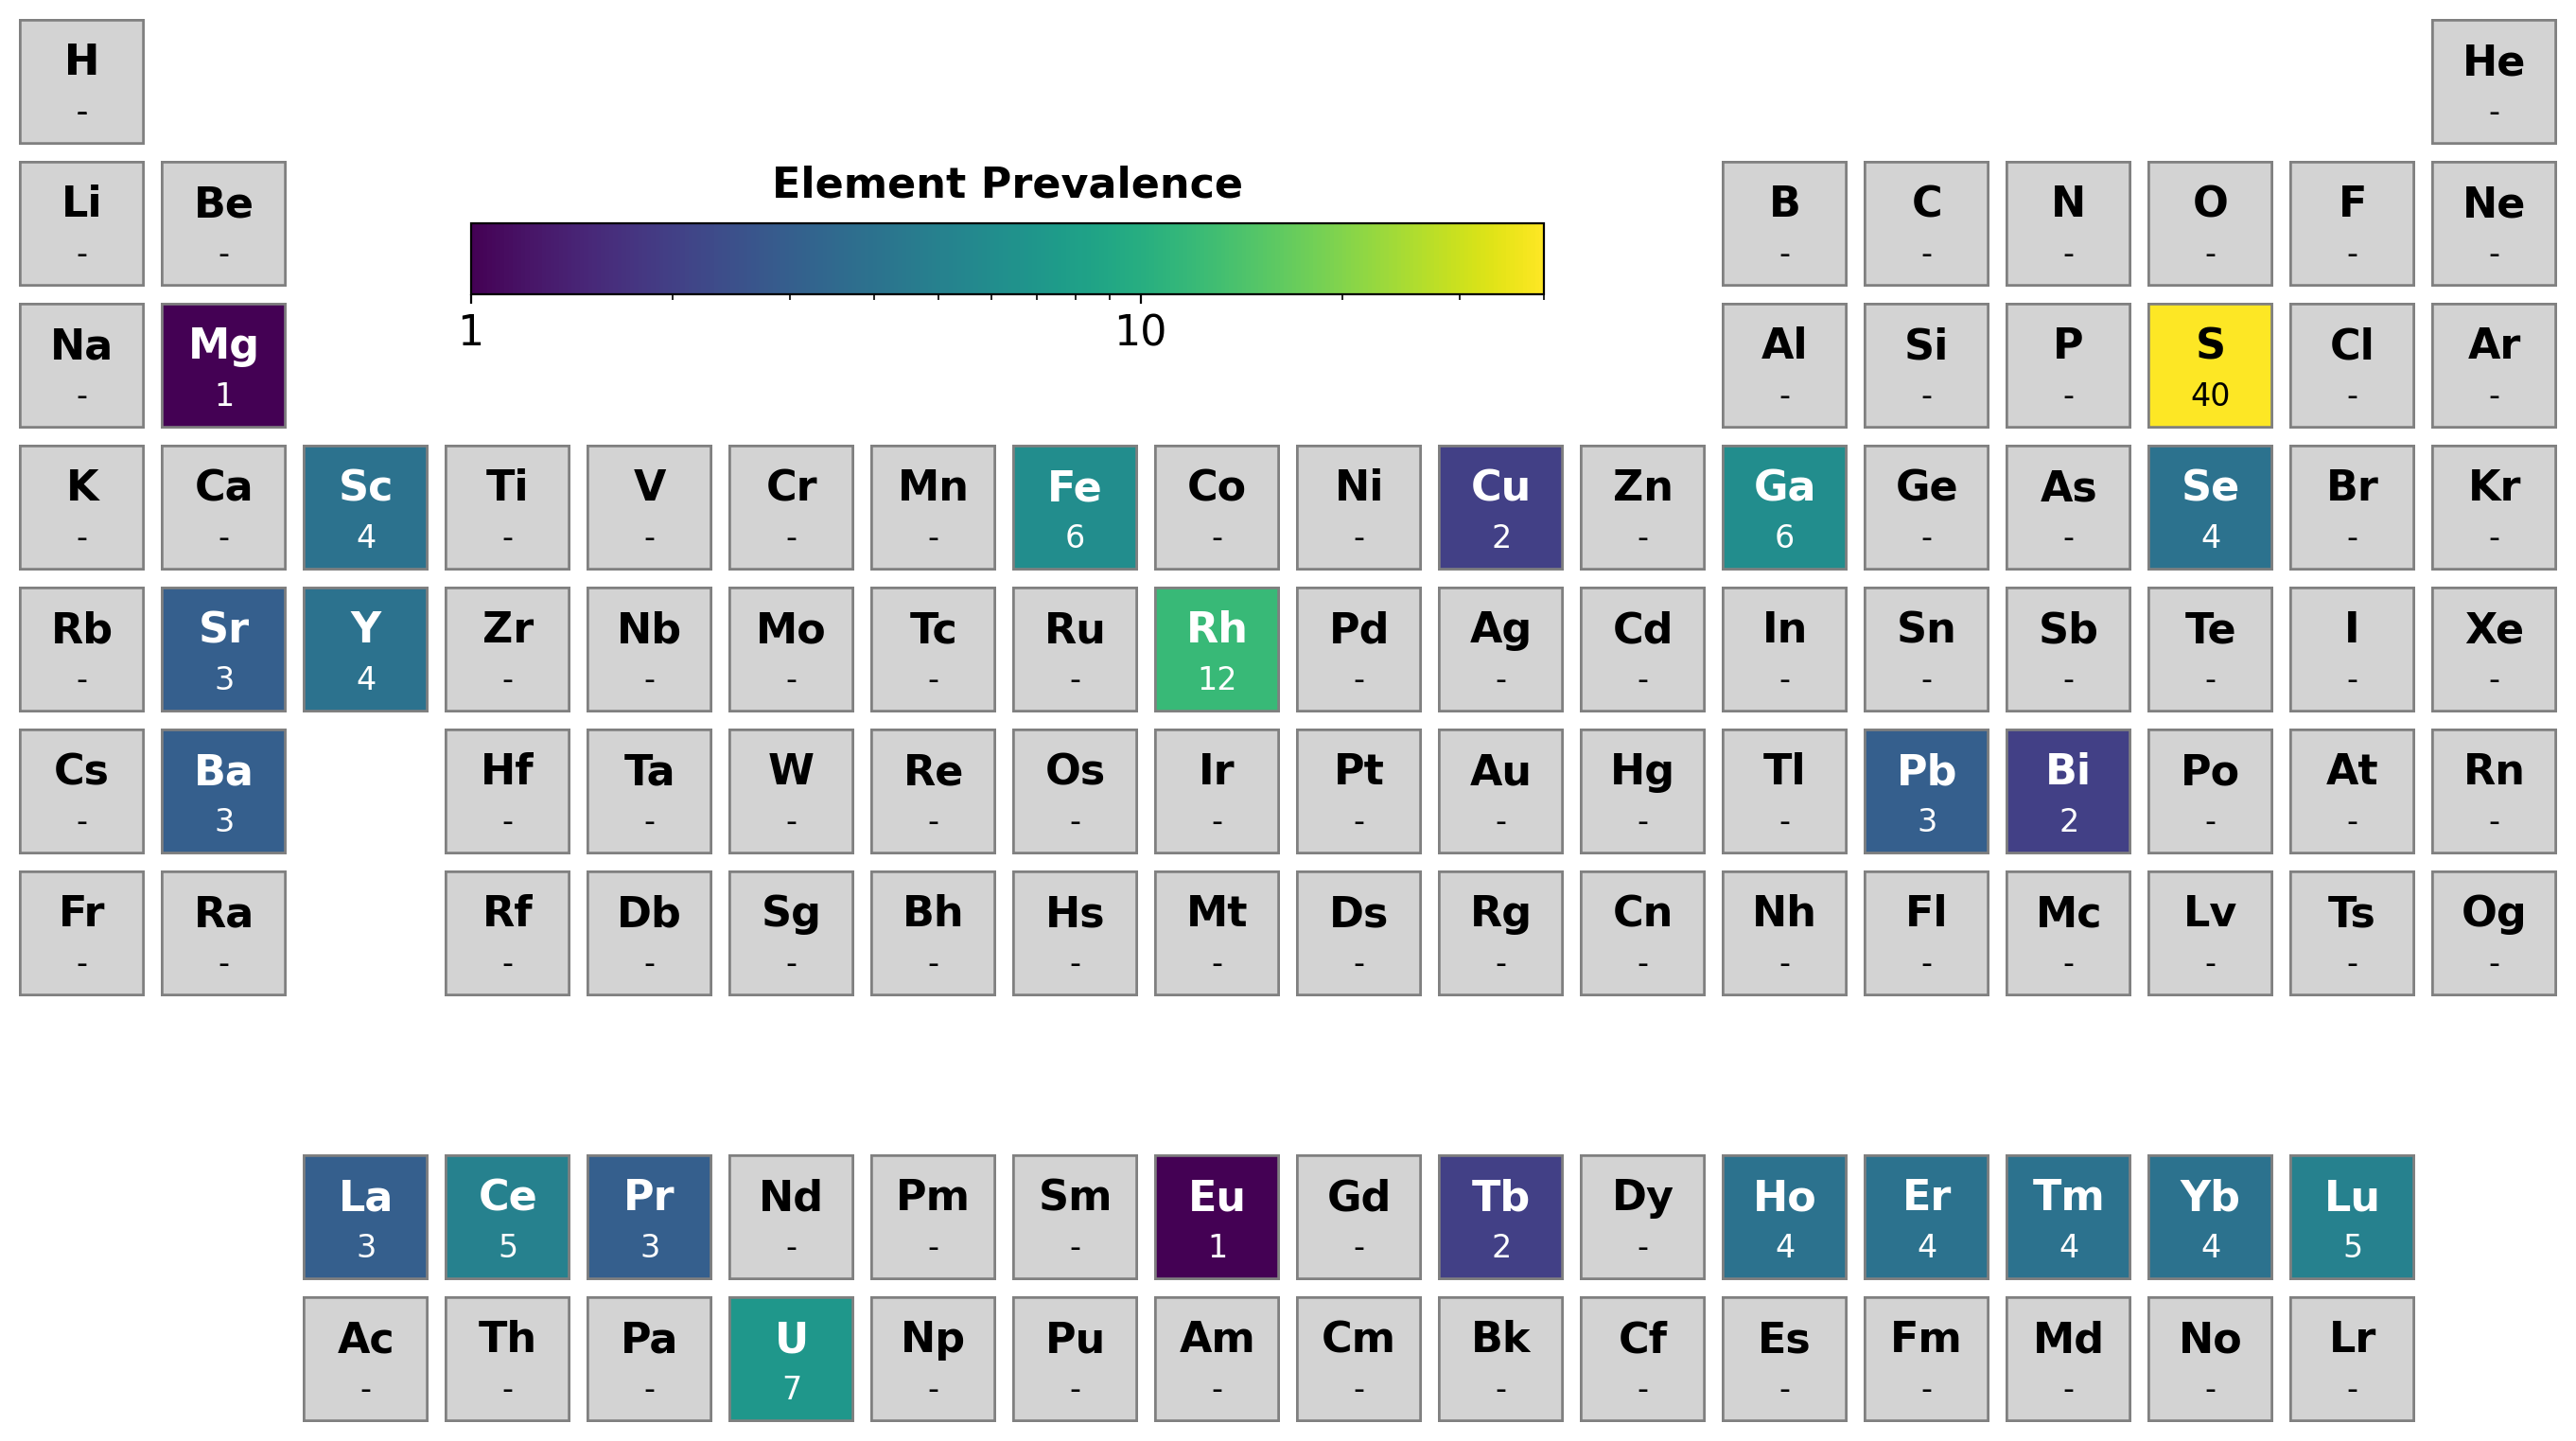

In [17]:
from tf_chpvk_pv.plots import graph_periodic_table

for t in tolerance_factor_dict_global.keys():
    if t not in ['t', 't_jess']:
        stable_candidates_t_sisso, df_out = check_stable_compositions(t, tolerance_factor_dict_path=new_tolerance_dict_path)
        graph_periodic_table(stable_candidates_t_sisso, t=t)

B,Al,Bi,Ce,Co,Cr,Cu,Dy,Er,Fe,Ga,...,Ta,Tb,Ti,Tl,Tm,U,V,Y,Yb,Zr
A,,,,,,,,,,,,,,,,,,,,,
Ba,NaN,NaN,5.852508e-01,0.000195,3.442018e-04,NaN,NaN,NaN,NaN,NaN,...,2.494720e-02,1.573748e-01,2.474918e-03,NaN,NaN,6.581163e-01,0.001310,NaN,NaN,6.668230e-02
Bi,0.000213,NaN,9.380592e-04,0.003356,4.165446e-03,NaN,NaN,3.282474e-01,9.661375e-03,0.004369,...,7.571312e-02,1.004145e-01,2.060993e-02,NaN,4.259474e-01,3.525914e-04,0.007306,2.510312e-01,5.226773e-01,NaN
Ca,NaN,NaN,2.725454e-01,0.000195,3.442018e-04,NaN,NaN,NaN,NaN,NaN,...,2.494720e-02,1.573748e-01,2.474918e-03,NaN,NaN,1.395944e-01,0.001310,NaN,NaN,6.668230e-02
Cd,NaN,NaN,1.632046e-01,0.000195,3.442018e-04,NaN,NaN,NaN,NaN,NaN,...,2.494720e-02,1.573748e-01,2.474918e-03,NaN,NaN,7.320481e-02,0.001310,NaN,NaN,6.668230e-02
Ce,0.000213,NaN,NaN,NaN,4.165446e-03,NaN,NaN,1.166758e-01,9.661375e-03,0.004369,...,NaN,NaN,NaN,NaN,1.768478e-01,2.167963e-05,NaN,7.844973e-02,2.526619e-01,NaN
Cu,0.000213,7.987753e-06,1.076103e-04,0.000195,2.500958e-05,NaN,9.012171e-24,6.766655e-18,9.661375e-03,0.004369,...,7.805553e-03,1.501288e-01,2.474918e-03,8.079768e-17,7.805634e-16,1.630910e-05,0.000215,5.015379e-20,3.845064e-14,6.668230e-02
Dy,0.000213,6.844900e-14,1.300417e-11,0.003356,4.165446e-03,NaN,NaN,2.262672e-04,9.661375e-03,0.004369,...,7.571312e-02,8.397644e-06,2.060993e-02,3.542768e-04,5.470186e-04,4.112095e-13,0.007306,1.002987e-04,1.225582e-03,NaN
Er,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.138738e-19,6.207480e-14,NaN
Eu,0.000213,5.316396e-11,2.472150e-09,0.003356,4.165446e-03,0.004425,2.621526e-04,1.473377e-03,9.661375e-03,0.004369,...,2.494720e-02,9.272159e-05,2.474918e-03,2.157291e-03,3.124271e-03,6.581163e-01,0.001310,7.396535e-04,6.227168e-03,6.668230e-02


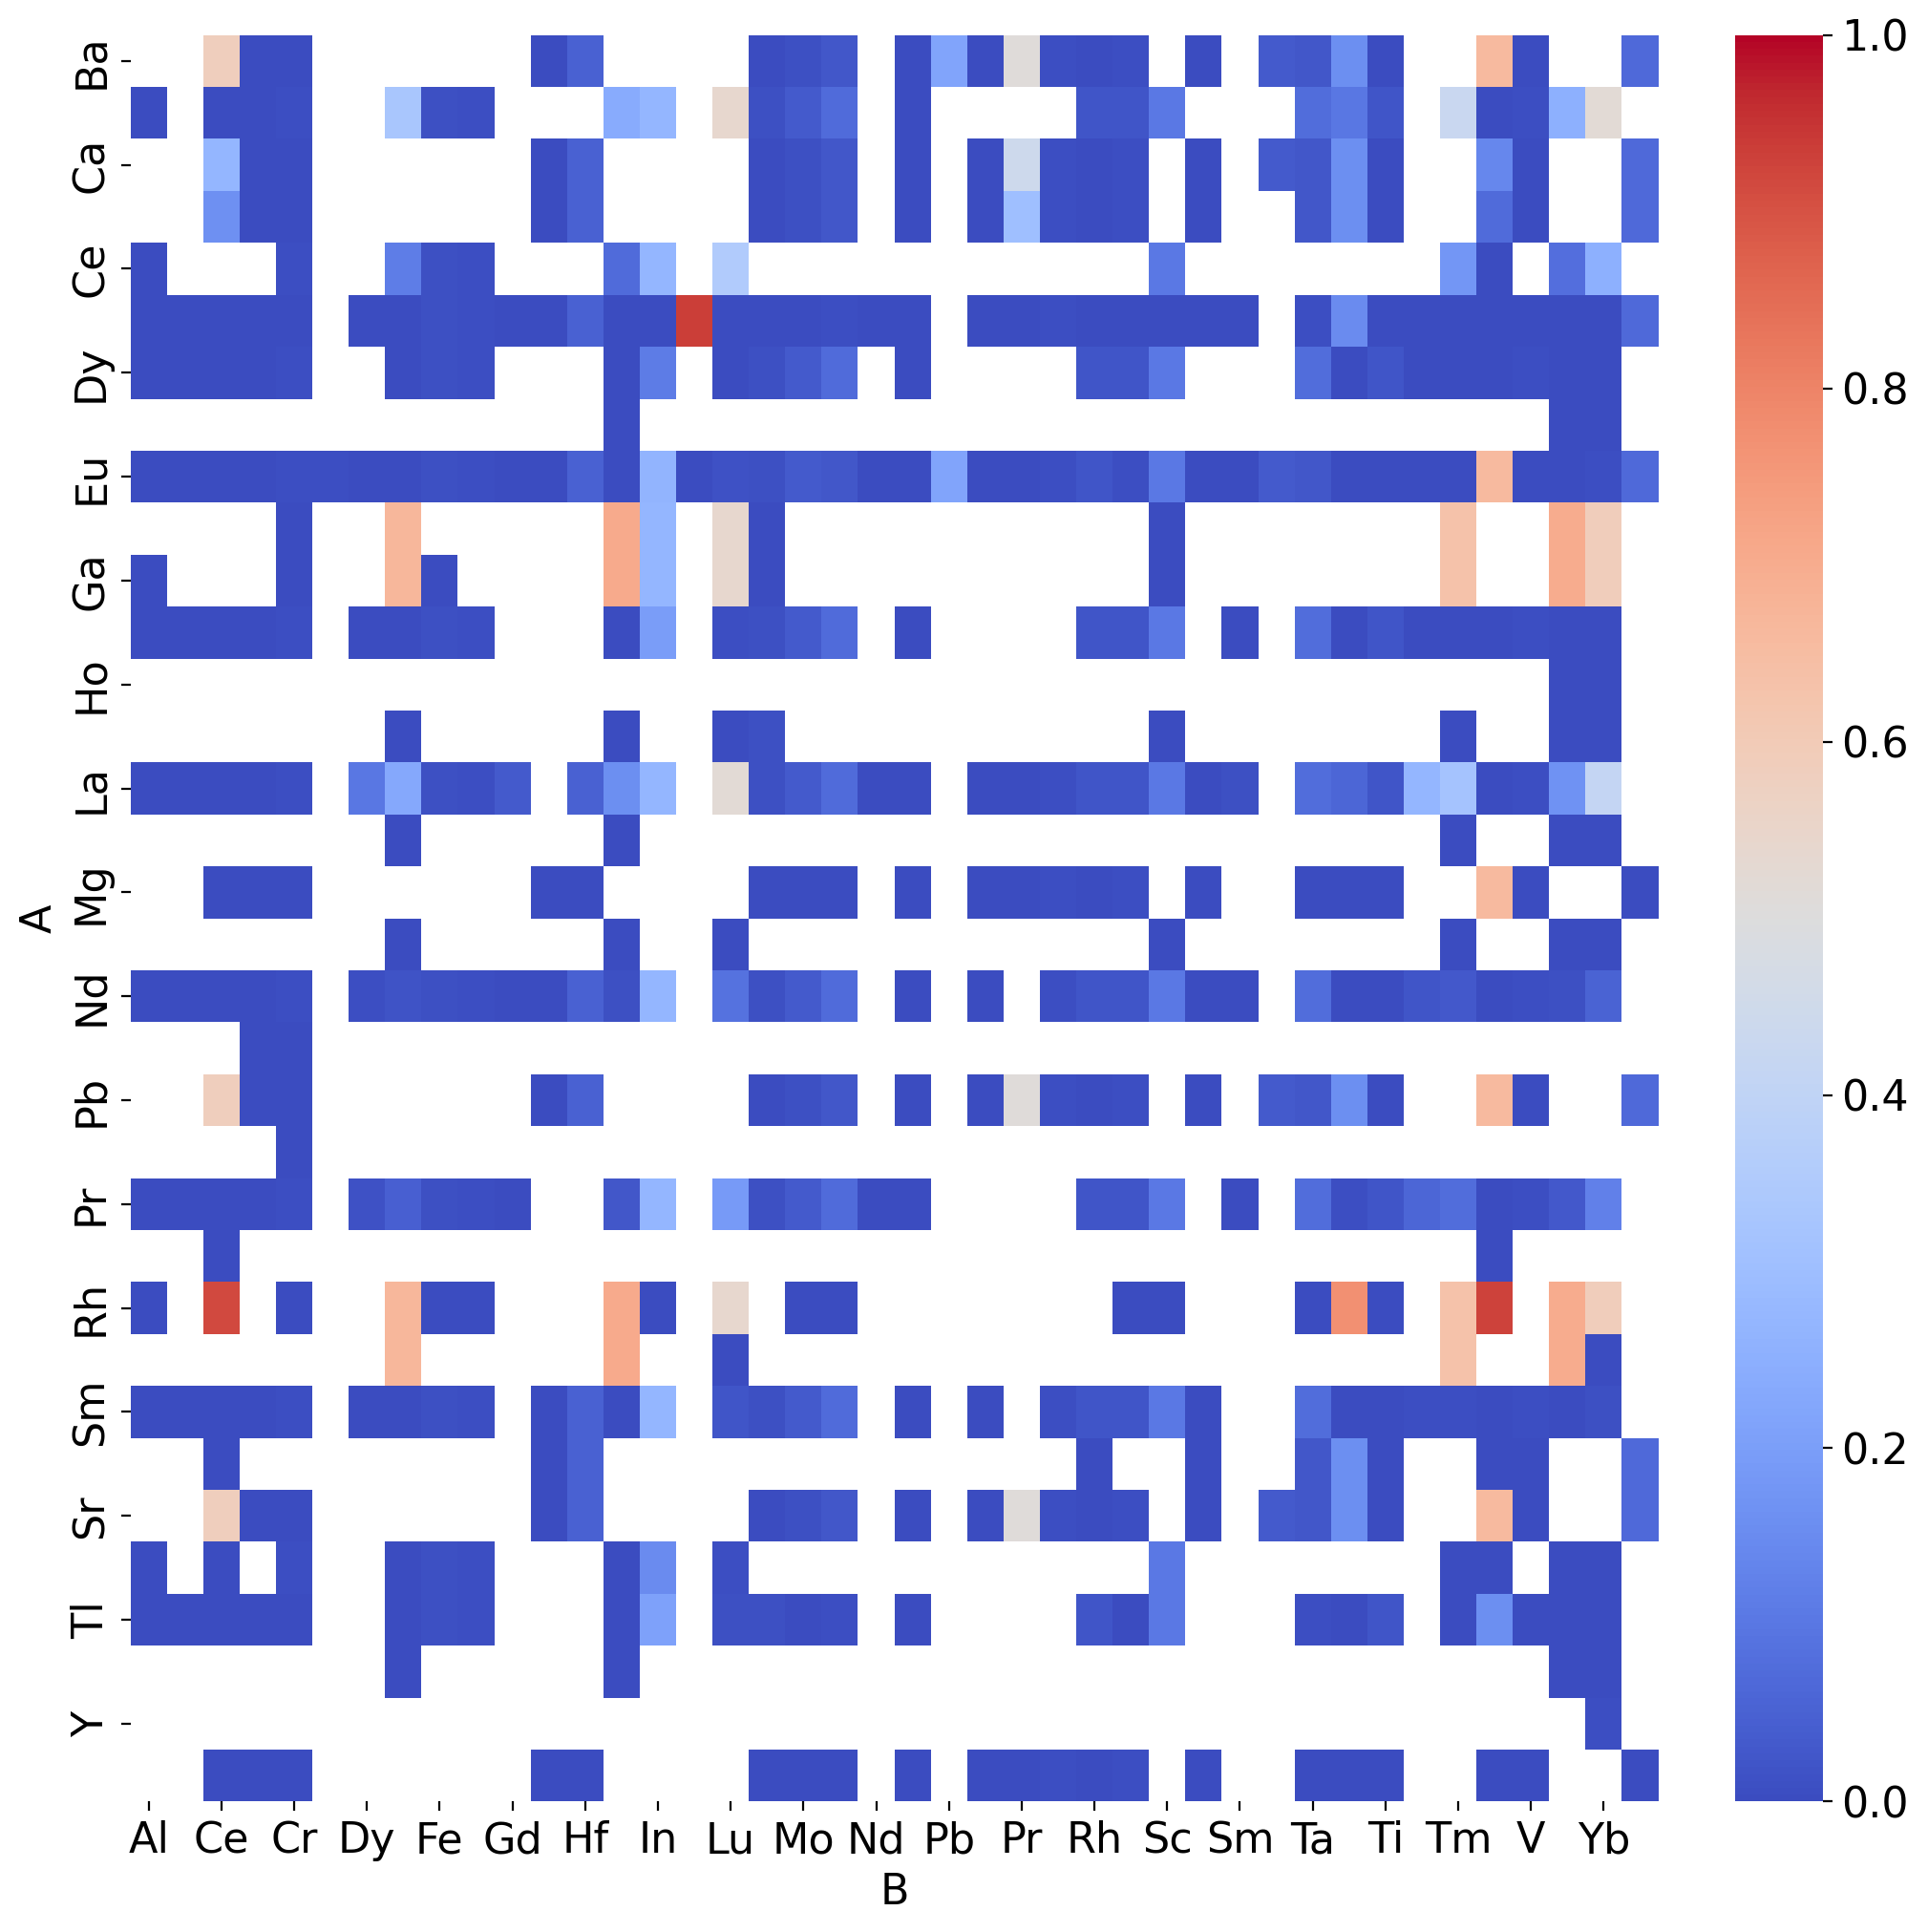

In [18]:
def plot_matrix(df_out, anion='S'):

    import seaborn as sns
    import matplotlib.pyplot as plt



    df_out = df_out[df_out['X'] == anion]
    #df_out = df_out[['rA', 'rB', 't_sisso_57']]

    df_plot = df_out.pivot(index='A', columns='B', values='p_t_sisso_57')
    #df_plot = df_plot < 4.377569

    """for a in df_plot.index:
        if df_plot.loc[a].isnull().sum() >= len(df_plot.columns)- 5:
            df_plot.drop(a, inplace=True)

    for b in df_plot.columns:
        if df_plot[b].isnull().sum() >= len(df_plot.index)- 10:
            df_plot.drop(columns=[b], inplace=True)"""

    display(df_plot)

    plt.figure(figsize=(10, 10))
    sns.heatmap(df_plot, cmap='coolwarm', vmin=0, vmax=1)    
    plt.show()

plot_matrix(df_generated_comp, anion='S')
    

According to t_sisso, 1128 (94.47236180904522%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


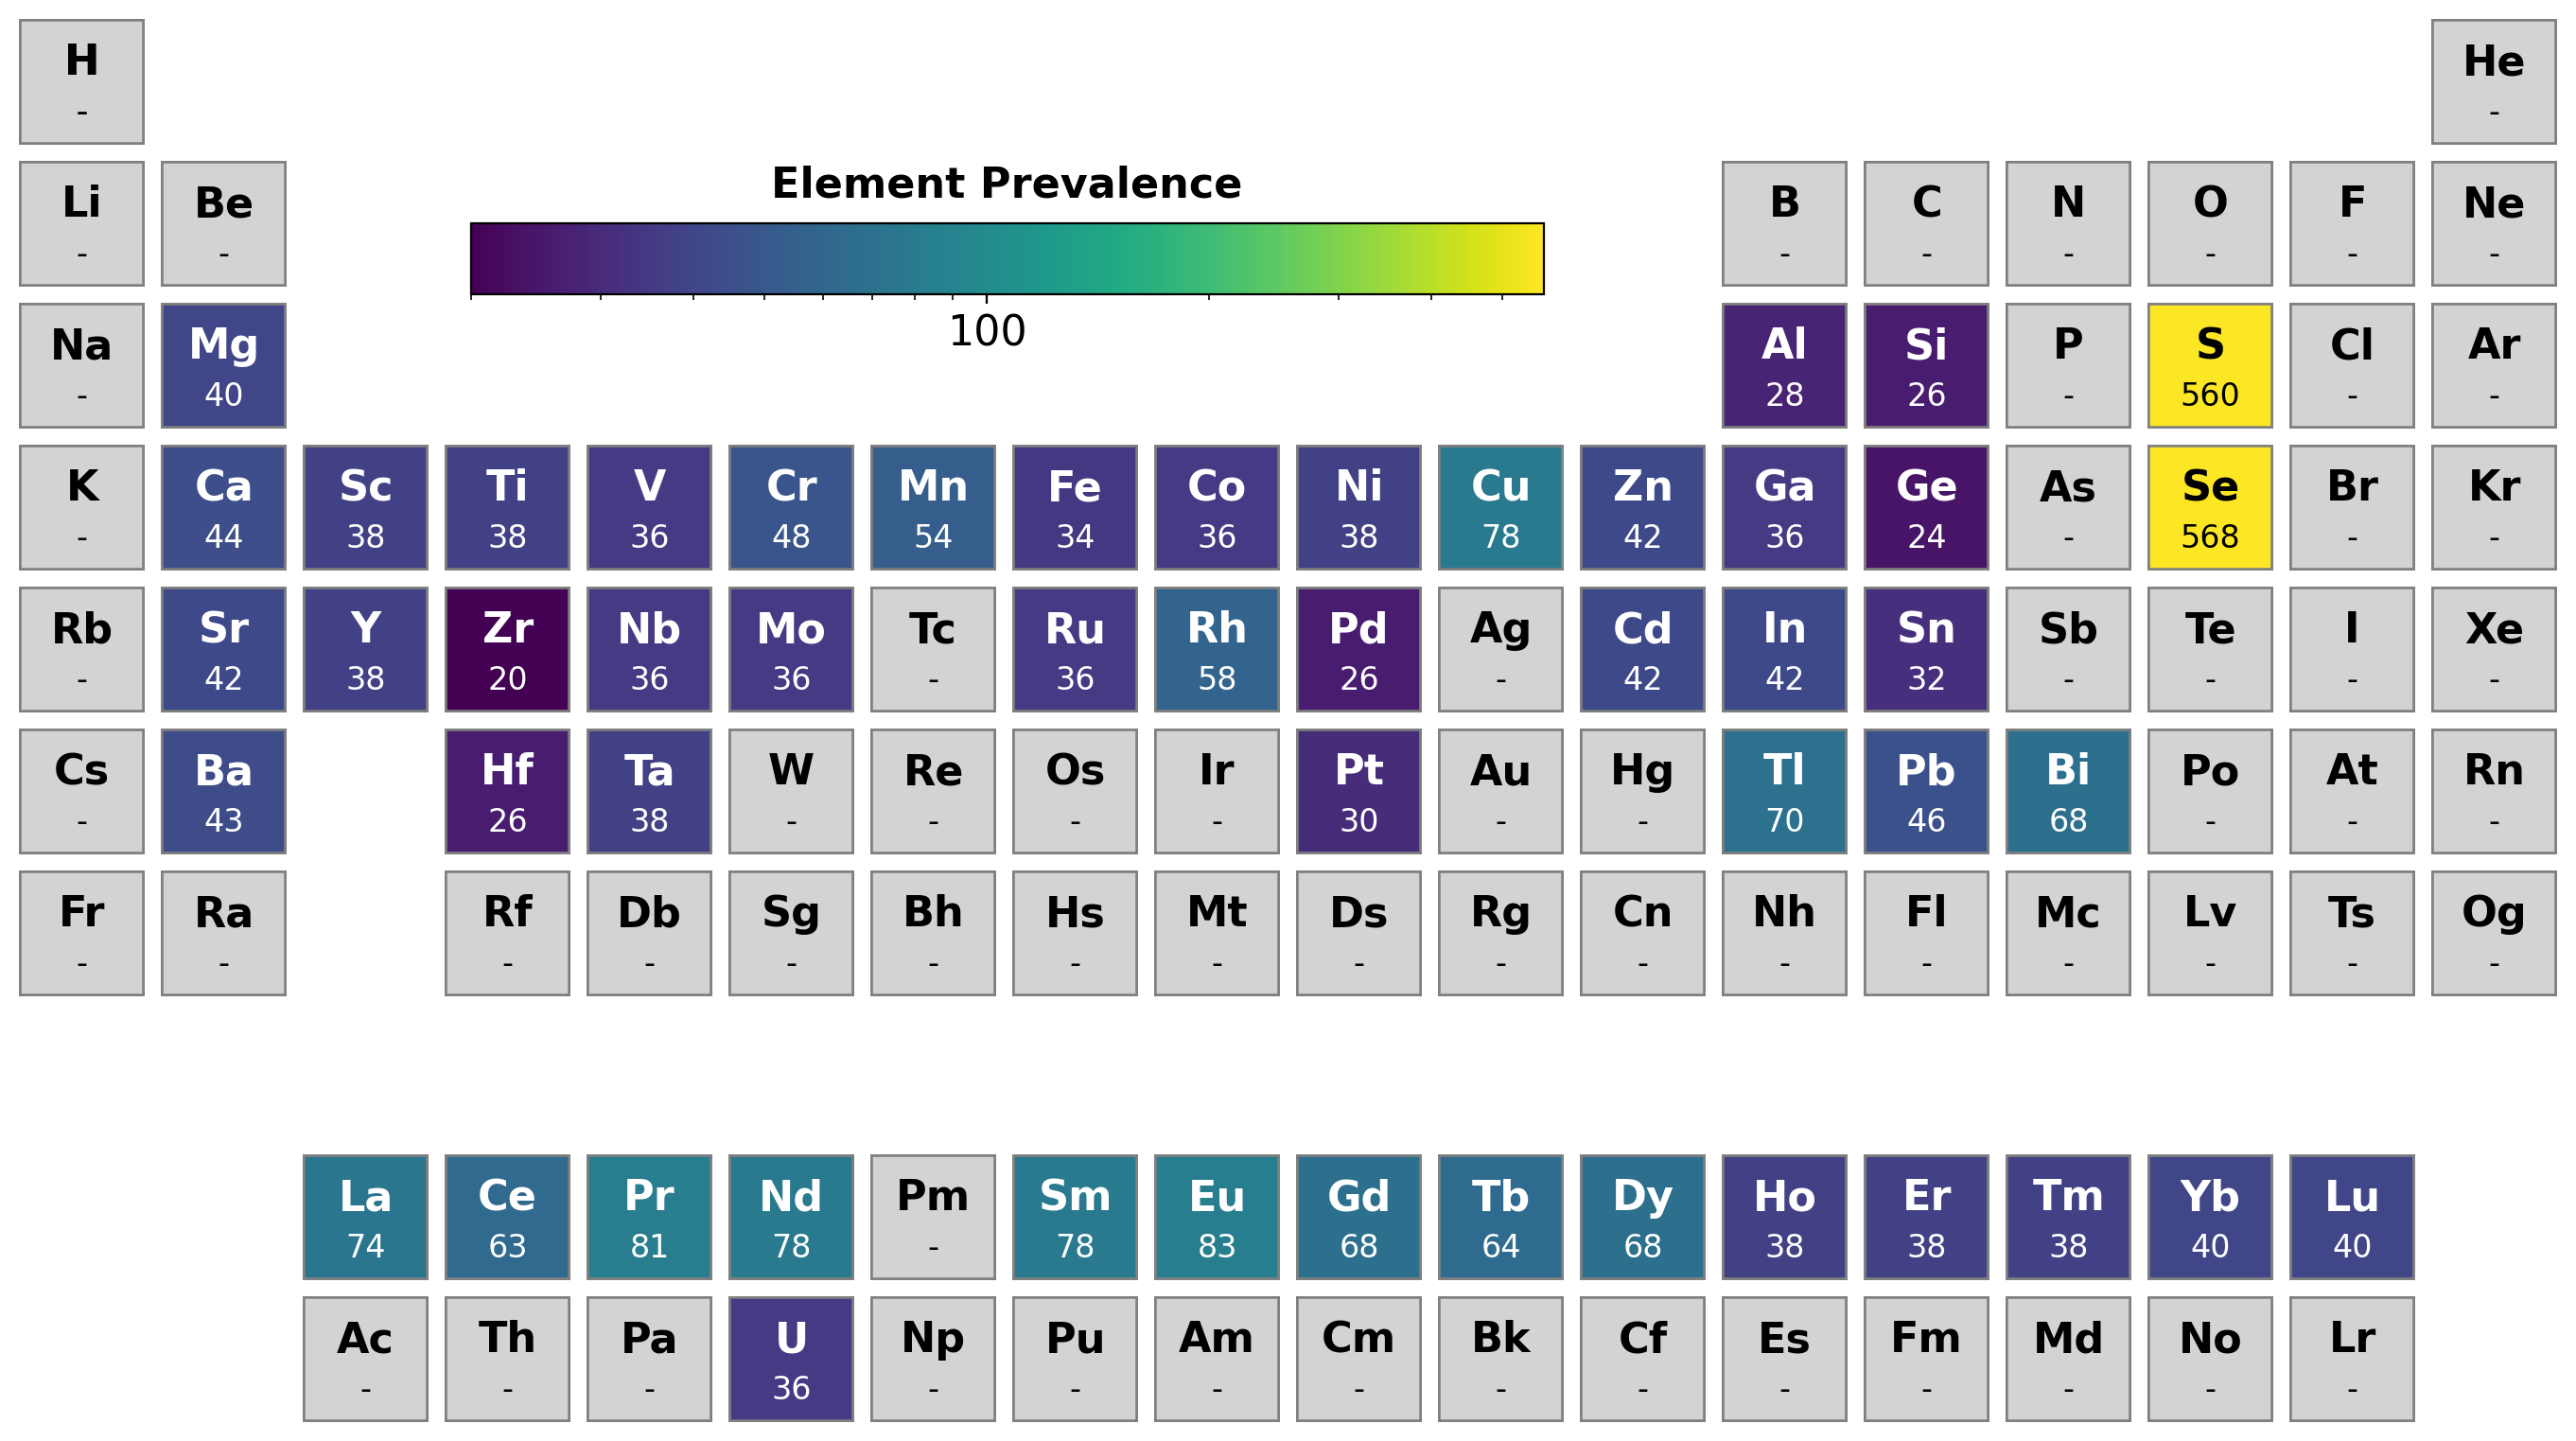

In [7]:
from tf_chpvk_pv.plots import graph_periodic_table

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso_127', tolerance_factor_dict_path=new_tolerance_dict_path)

graph_periodic_table(stable_candidates_t_sisso)